<h1><center>Laboratorio 10: Adivina, Adivinador 🔮</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2025</strong></center>

### Cuerpo Docente:

- Profesores: Diego Cortez, Gabriel Iturra
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Nicolás Cabello, Cristopher Urbina

### **Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados**

- Nombre de alumno 1: María Jesús Valenzuela
- Nombre de alumno 2: Matías Zúñiga

### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/jesuvalenzuela/NanSquad)

## Temas a tratar
- Series de Tiempo.
- Predicciones vía `Prophet`.
- Implementar un sistema de recomendación utilizando `surprise`.

## Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: Entregas Miercoles a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda **fuertemente** asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

### Objetivos principales del laboratorio
- Comprender qué es una serie de tiempo y su estructura.
- Identificar tendencias, estacionalidades e irregularidades.
- Armar un modelo predictivo para la serie.
- Conocer y aplicar sistemas de recomendación.
- Entender estructura y conocer casos de estudio.


In [88]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except:
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


In [128]:
#Librerías utilizadas en el proyecto

# Librerías estándar
# ===============================
import warnings
import copy
import random
from collections import defaultdict

# ===============================
# Manejo de datos
# ===============================
import numpy as np
import pandas as pd

# ===============================
# Visualización
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ===============================
# Prophet (series de tiempo)
# ===============================
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# ===============================
# Machine Learning general
# ===============================
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

# ===============================
# Statsmodels
# ===============================
from statsmodels.tsa.stattools import pacf

# ===============================
# NLP (Bag of Words)
# ===============================
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ===============================
# Surprise (recomendación)
# ===============================
from surprise import Dataset, Reader, KNNBasic, accuracy, SVD, NMF
from surprise.model_selection import train_test_split
from surprise.accuracy import mae


# **1. Forecasting (30 puntos)**


## **Prophet**

Prophet es una herramienta open-source de Facebook utilizada para realizar predicciones en series de tiempo. Esta se basa en la descomposición aditiva, donde tendencias no lineales se ajustan junto a la estacionalidad.

En la ecuación de a continuación se puede ver una idea general de los elementos que construyen a un modelo aditivo como lo es Prophet.

\begin{equation}
y(t) = g(t) + s(t) + h(t) + e(t)
\end{equation}

Donde, $g(t)$ hace referencia a las tendencias, que corresponden a cambios graduales en largos periodos de tiempo. $s(t)$ corresponde a la estacionalidad, son cambios periodicos o cortos en el tiempo. $h(t)$ es el efecto que tienen las festividades sobre las predicciones, mientras que e(t) corresponde al error o ruido. Finalmente $y(t)$, es la predicción hecha por el modelo.

Prophet trabaja por defecto con Piece-Wise Lineal Model, este es un modelo de regresión lineal, en el cual se buscan distintas zonas en que la data presente patrones o tendencias lineales, de estas zonas obtiene su regresión y luego las "une" de manera de representar toda la región, como se puede ver en la ecuación siguiente.

\begin{equation}
y(x)=
    \begin{cases}
        η_1 + \beta_1(x-b_1), & b_1 < x  \leqslant b_2 \\
        η_2 + \beta_2(x-b_2), & b_2 < x  \leqslant b_3 \\
        η_3 + \beta_3(x-b_3), & b_3 < x  \leqslant b_3 \\
        ... \\
        η_k + \beta_{nb}(x-b_{nb-1}), & b_{n-1} < x  \leqslant b_{nb} \\
    \end{cases}
\end{equation}

Siendo $b_1$ el primer punto de quiebre en la serie y así hasta el punto $b_{nb}$ correspondiente al último punto de quiebre de la serie con una cantidad $nb$ de puntos.

Para mayor información de Prophet y como utilizarla, pueden ver su [documentación](https://facebook.github.io/prophet/docs/quick_start.html#python-api), donde hay pueden encontrar un pequeño tutorial de la librería.

## **La Factura de Homero**

<center>
<img src ="https://i.makeagif.com/media/7-30-2018/H_ZAY1.gif" width = 500 />

Homero Simpson ha trabajado en la Planta Nuclear de Springfield por más de 20 años como Inspector de Seguridad, pero recientemente el Sr. Burns le ha permitido trabajar desde casa. Aunque le encanta la flexibilidad que esto le otorga, también ha notado un aumento considerable en su consumo energético en el hogar. Con el uso constante de calefacción en invierno y aire acondicionado en verano, Homero está preocupado por cómo afectará esto a su presupuesto en los próximos meses, ya que planea pasar aún más tiempo en casa.

Afortunadamente, gracias a su puesto en la Planta de Energía Nuclear, Homero tiene acceso a los datos de consumo de energía de cada ciudadano en Springfield, por lo que accede a esta información y almacena el consumo de su hogar en un archivo llamado `energia_homero.csv`. Este archivo posee el consumo diario en el hogar de Homero Simpson desde el Junio del 2016 hasta Julio del 2020.

Con esta valiosa información, Homero espera poder predecir su consumo energético y tomar decisiones informadas para ajustar su presupuesto mensual.

Los datos son los siguientes:

* **date**: Fecha de medición.
* **Energy_kWh**: Consumo diario de energía eléctrica en el hogar de Homero (en kWh).

## 1.1 Series de Tiempo [0 puntos]

### Carga de los datos

En primer lugar, cargue los datos históricos del archivo `energia_homero.csv` al entorno de trabajo. Una vez cargados, asegúrense de transformar la columna `date` a formato `datetime`. Además, visualice el consumo de energía en la casa de Homero mediante la librería `plotly`.


In [91]:
ls

Lab10_enunciado.ipynb  datos_frink.csv
cervezas.csv           energia_homero.csv


**Respuesta**:

In [92]:
#CODIGO AQUI

# Cargar datos historicos
df = pd.read_csv("energia_homero.csv")

# Transformar la columna de fecha
df["date"] = pd.to_datetime(df["date"])

# Mostrar las primeras filas
df.head(10)

,date,Energy_kWh
0,2016-06-01,29.691
1,2016-06-02,28.789
2,2016-06-03,19.247
3,2016-06-04,22.883
4,2016-06-05,25.195
5,2016-06-06,29.323
6,2016-06-07,30.322
7,2016-06-08,40.051
8,2016-06-09,38.667
9,2016-06-10,42.467


## 1.2 Controlando la Serie de Tiempo [6 puntos]

<center>
<img src ="https://i.pinimg.com/originals/66/77/88/667788e0b1f08ff1e1cfce11d303b203.gif" width = 500 />

Luego de leer mucho, Homero cree que necesita descomponer la serie de tiempo para poder controlar estos componentes de forma efectiva y lograr que la serie tenga propiedades de una serie estacionaria.

Usted, como buen ciudadano de Springfield, decide ayudar a Homero, el cual le pide que realice lo siguientes pasos:

0. Cree un conjunto de entrenamiento y uno de prueba (a proyectar). Para ello, considere como entrenamiento la información **hasta** el `2020-02-29` y como conjunto de prueba **desde** el `2020-03-01`. [0 puntos]
1. Cree un `Pipeline` que permita obtener una representación de la tendencia de la serie de tiempo, mediante un modelo Lineal. Nombre al pipeline `Pipeline_trend`. [1 punto]
2. Entrene el modelo lineal y luego obtenga predicciones tanto para el conjunto de entrenamiento como para el de prueba (intervalo completo de tiempo). Luego grafique las predicciones y calcule el `Mean Absolute Error` (MAE), tanto para el conjunto de prueba como para el de entrenamiento. [1 punto]
3. Grafique el error (Valor real - Valor predicho) para todo el intervalo de tiempo y responda ¿Hay un comportamiento estacional en la serie? [1 punto]
4.  Cree un `Pipeline` que permita modelar la estacionalidad de la serie temporal mediante términos de Fourier y la represente a través de una Regresión Lineal de la variable objetivo. Nombre a este pipeline `Pipeline_seasonal`. Determine el valor de Periodos `P` y el número de terminos de Fourier `n`. [1 punto]
5. Entrene el nuevo modelo y obtenga predicciones en el intervalo completo de tiempo. Luego grafique y calcule el `MAE` en el conjunto de prueba y en el de entrenamiento. [1 punto]
6. Vuelva a graficar el error y comente los resultados. [1 punto]

**Respuesta**

Shape train: (1369, 3), test: (129, 3)
[Tendencia] MAE train: 10.568 | MAE test: 8.656


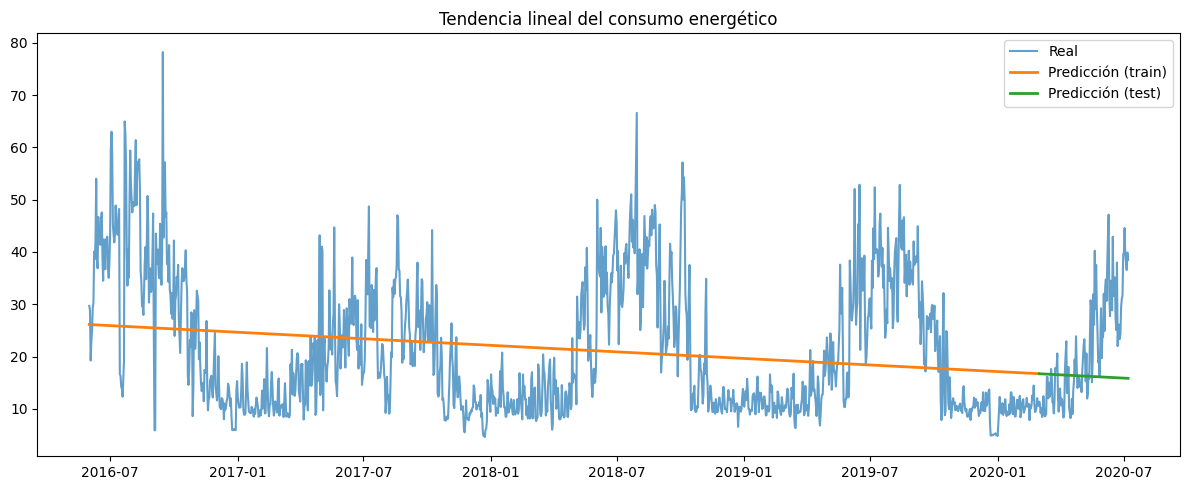

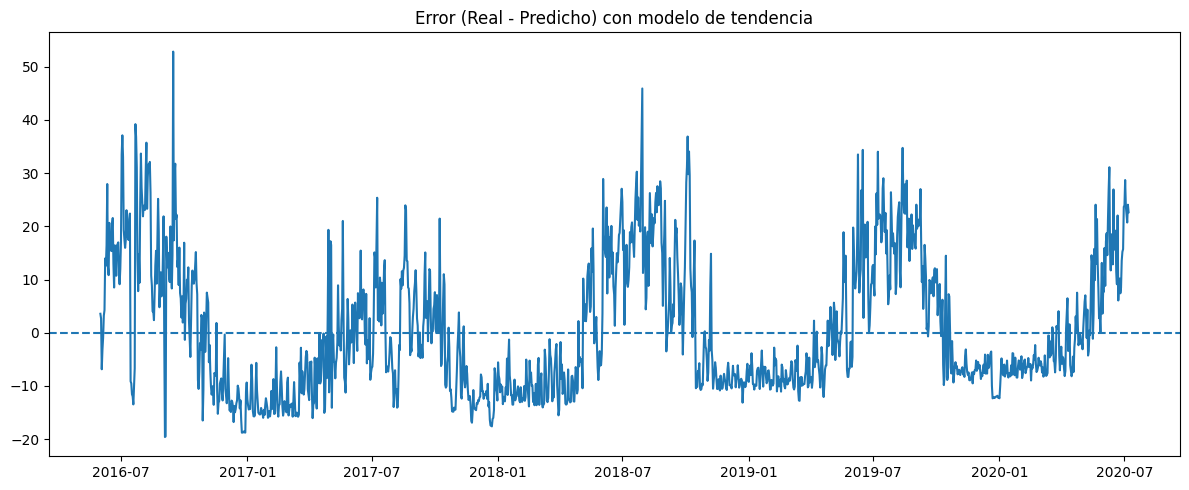

[Fourier]   MAE train: 5.383 | MAE test: 4.230


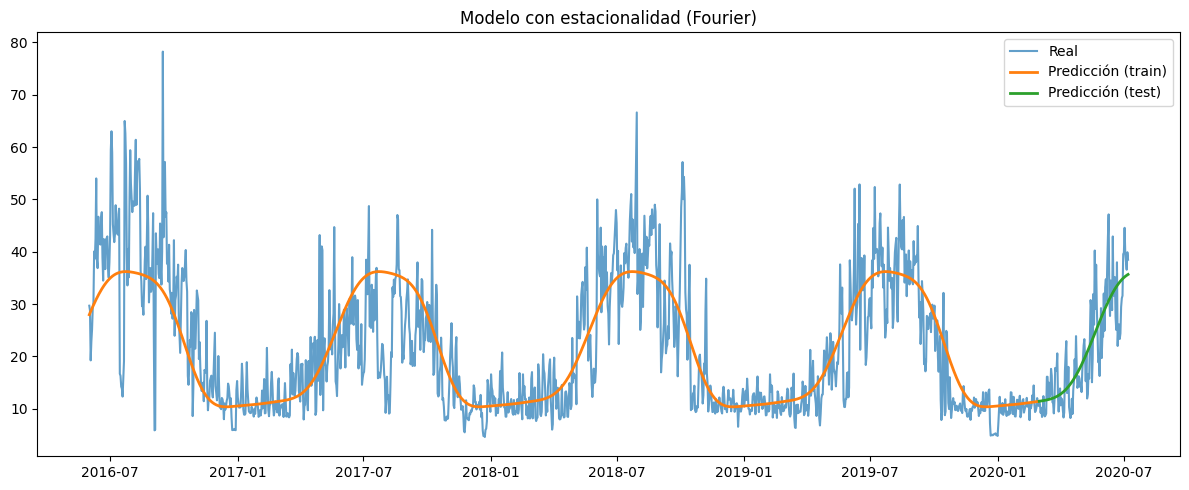

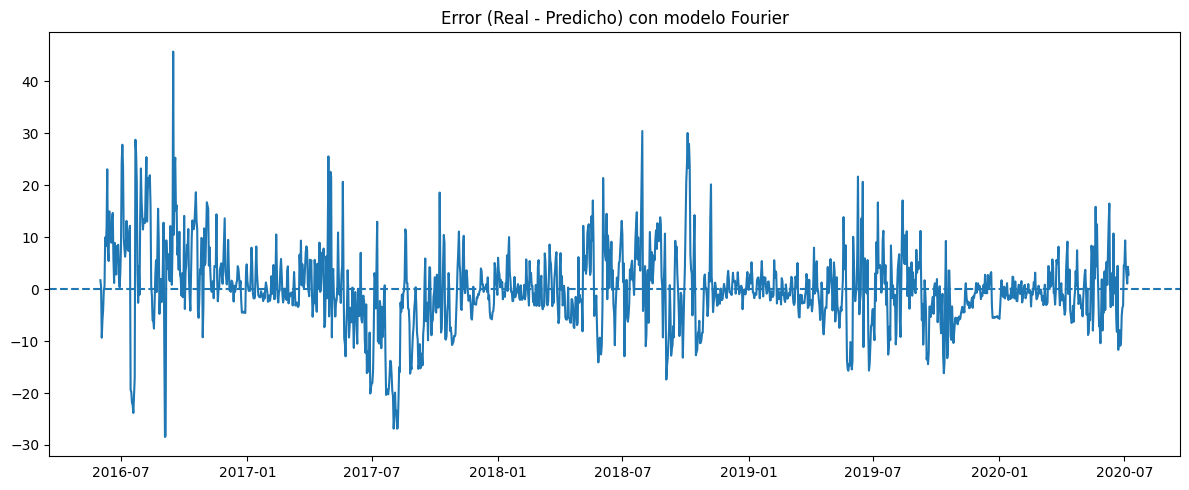


Resumen de desempeño (MAE):
                  Modelo  MAE_train  MAE_test
        Tendencia lineal  10.568154  8.655814
Estacionalidad (Fourier)   5.382917  4.230167


In [93]:
#CODIGO AQUI

# 1.2 Controlando la Serie de Tiempo
# =========================
# --- 0) Preparar datos ---
df = df.sort_values("date").reset_index(drop=True)

# Variable de tiempo (días desde el inicio)
t0 = df["date"].min()
df["t"] = (df["date"] - t0).dt.days

# Split temporal: train hasta 2020-02-29, test desde 2020-03-01
train = df[df["date"] <= "2020-02-29"].copy()
test  = df[df["date"] >= "2020-03-01"].copy()

Xtr, ytr = train[["t"]], train["Energy_kWh"]
Xte, yte = test[["t"]],  test["Energy_kWh"]

print(f"Shape train: {train.shape}, test: {test.shape}")

# --- 1) Pipeline_trend: Tendencia lineal ---
Pipeline_trend = Pipeline([
    ("regressor", LinearRegression())
])

Pipeline_trend.fit(Xtr, ytr)

train_pred = Pipeline_trend.predict(Xtr)
test_pred  = Pipeline_trend.predict(Xte)

mae_train = mean_absolute_error(ytr, train_pred)
mae_test  = mean_absolute_error(yte, test_pred)

print(f"[Tendencia] MAE train: {mae_train:.3f} | MAE test: {mae_test:.3f}")

# --- 2) Gráficos: predicciones y error (tendencia) ---
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["Energy_kWh"], label="Real", alpha=0.7)
plt.plot(train["date"], train_pred, label="Predicción (train)", linewidth=2)
plt.plot(test["date"], test_pred, label="Predicción (test)", linewidth=2)
plt.title("Tendencia lineal del consumo energético")
plt.legend()
plt.tight_layout()
plt.show()

# Error global (real - predicho) para toda la serie con el modelo de tendencia
df_err_trend = df.copy()
df_err_trend["y_hat_trend"] = Pipeline_trend.predict(df[["t"]])
df_err_trend["error_trend"] = df_err_trend["Energy_kWh"] - df_err_trend["y_hat_trend"]

plt.figure(figsize=(12,5))
plt.plot(df_err_trend["date"], df_err_trend["error_trend"])
plt.axhline(0, linestyle="--")
plt.title("Error (Real - Predicho) con modelo de tendencia")
plt.tight_layout()
plt.show()

# --- 3) Fourier features para estacionalidad ---
def fourier_features(t, p=365, n=3):
    """
    t: array de tiempos en días
    p: periodo (365 días ~ anual)
    n: número de términos de Fourier (pares sin/cos)
    retorna: matriz [len(t) x (2n)] con sin(2πkt/p), cos(2πkt/p) para k=1..n
    """
    t = np.asarray(t).reshape(-1)
    feats = []
    for k in range(1, n+1):
        feats.append(np.sin(2*np.pi*k*t/p))
        feats.append(np.cos(2*np.pi*k*t/p))
    return np.column_stack(feats)

class FourierFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, p=365, n=3):
        self.p = p
        self.n = n
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # X es un DataFrame/array con una columna 't'
        if hasattr(X, "values"):
            t = X.values.ravel()
        else:
            t = np.asarray(X).ravel()
        return fourier_features(t, p=self.p, n=self.n)

# --- 4) Pipeline_seasonal: Estacionalidad con Fourier + Regresión Lineal ---
Pipeline_seasonal = Pipeline([
    ("fourier", FourierFeaturizer(p=365, n=5)),  # puedes probar n=3,4,5...
    ("regressor", LinearRegression())
])

Pipeline_seasonal.fit(Xtr, ytr)

train_pred2 = Pipeline_seasonal.predict(Xtr)
test_pred2  = Pipeline_seasonal.predict(Xte)

mae_train2 = mean_absolute_error(ytr, train_pred2)
mae_test2  = mean_absolute_error(yte, test_pred2)

print(f"[Fourier]   MAE train: {mae_train2:.3f} | MAE test: {mae_test2:.3f}")

# --- 5) Gráficos: predicciones y error (Fourier) ---
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["Energy_kWh"], label="Real", alpha=0.7)
plt.plot(train["date"], train_pred2, label="Predicción (train)", linewidth=2)
plt.plot(test["date"], test_pred2, label="Predicción (test)", linewidth=2)
plt.title("Modelo con estacionalidad (Fourier)")
plt.legend()
plt.tight_layout()
plt.show()

df_err_fourier = df.copy()
df_err_fourier["y_hat_fourier"] = Pipeline_seasonal.predict(df[["t"]])
df_err_fourier["error_fourier"] = df_err_fourier["Energy_kWh"] - df_err_fourier["y_hat_fourier"]

plt.figure(figsize=(12,5))
plt.plot(df_err_fourier["date"], df_err_fourier["error_fourier"])
plt.axhline(0, linestyle="--")
plt.title("Error (Real - Predicho) con modelo Fourier")
plt.tight_layout()
plt.show()

# --- 6) Resumen rápido para reportar ---
summary = pd.DataFrame({
    "Modelo": ["Tendencia lineal", "Estacionalidad (Fourier)"],
    "MAE_train": [mae_train, mae_train2],
    "MAE_test":  [mae_test,  mae_test2]
})
print("\nResumen de desempeño (MAE):")
print(summary.to_string(index=False))

3. Error con modelo de tendencia

El gráfico del error muestra un patrón claramente periódico, con ciclos que se repiten aproximadamente una vez por año. Esto evidencia la presencia de estacionalidad en la serie, ya que los residuos no son aleatorios, sino que siguen una forma ondulada recurrente. Por lo tanto, el modelo lineal simple no logra capturar por completo la dinámica del consumo energético.

6. Error con modelo Fourier

En el modelo con términos de Fourier, los errores se distribuyen de manera mucho más aleatoria alrededor de cero, sin mostrar estructura periódica ni tendencia visible. Esto indica que la estacionalidad fue correctamente modelada, y que el modelo captura los patrones anuales del consumo energético, reduciendo significativamente el error respecto al modelo lineal.

## 1.3 Un Consejo para Homero [6 puntos]

<center>
<img src ="https://media.tenor.com/sjbvGMLZiDkAAAAM/the-simpsons-homner-simpson.gif" width = 400 />

Homero al observar los resultados obtenidos, se mostró conforme y decidió no seguir averiguando al respecto. Usted, como buen amigo y utilizando sus recientes conocimientos en Forecast, le sugiere a Homero utilizar **Prophet**, una herramienta de modelado de series de tiempo que incluye descomposición de tendencias y estacionalidad, así como la capacidad de incorporar regresores adicionales. Usted le explica a Homero que Prophet es especialmente útil para realizar pronósticos cuando hay patrones estacionales y que podría mejorar los resultados que ha obtenido hasta ahora.

Homero, algo agotado debido al exhaustivo estudio que hizo para entender como funciona esta herramienta, le solicita ayuda para implementar Prophet y evaluar si puede obtener mejores resultados en sus predicciones de consumo energético.

Dado esto, Homero le pide que realice los siguientes pasos:

1. Instale y cargue Prophet a su entorno de trabajo. Luego renombre la variable temporal `date` por `ds` y la variable objetivo `Energy_kWh` por `y`, en los conjuntos de entrenamiento y de prueba. [1 punto]
2. Cree y ajuste el modelo Prophet con sus datos de entrenamiento. Luego realice prepare el dataset de predicciones con su set de prueba y realice las predicciones. `Nota:` Le puede ser útil este [Enlace](https://facebook.github.io/prophet/docs/quick_start.html#python-api) [2 puntos]
3. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
4. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y de prueba. [1 punto]
5. Grafique el error (Valor real - Valor predicho) en todo el intervalo de tiempo. Analice sus resultados y responda: ¿Hay un comportamiento estacional en la serie? [1 punto]

**Respuesta:**

[Prophet] MAE train: 4.820 | MAE test: 4.956


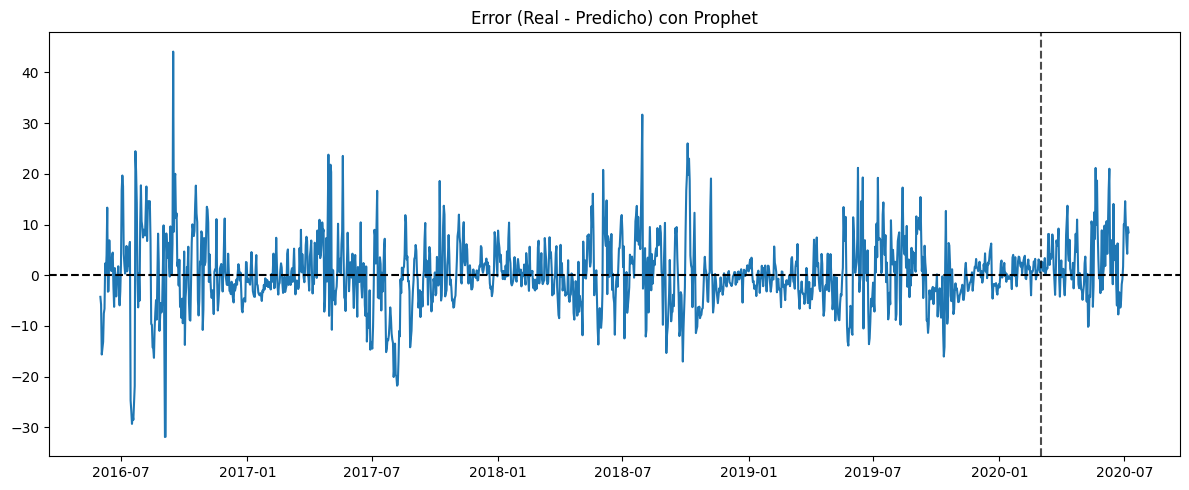


Resumen de desempeño Prophet:
MAE entrenamiento: 4.820
MAE prueba:        4.956


In [94]:
#CODIGO AQUI

# 1.3 Un Consejo para Homero — Prophet (6 pts)
# ===========================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# Plotly es opcional; si falla el render, hacemos fallback a Matplotlib
_PLOTLY_OK = True
try:
    import plotly.io as pio
    from prophet.plot import plot_plotly, plot_components_plotly
    try:
        pio.renderers.default = "vscode"   # para VS Code
    except Exception:
        pio.renderers.default = "browser"  # alternativa segura
except Exception:
    _PLOTLY_OK = False

# --- Preparar formato Prophet (sin recargar nada) ---
train_prophet = train.rename(columns={"date": "ds", "Energy_kWh": "y"}).copy()
test_prophet  = test.rename(columns={"date": "ds", "Energy_kWh": "y"}).copy()

# --- Crear y ajustar el modelo ---
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive"   
)
m.fit(train_prophet)  # SOLO con train

# --- Predicciones coherentes en todo el rango (train + test) ---
future_all = pd.concat([train_prophet[["ds"]], test_prophet[["ds"]]]) \
               .drop_duplicates().sort_values("ds")
forecast_all = m.predict(future_all)

# --- Métricas en train y test ---
pred_train = train_prophet.merge(forecast_all[["ds", "yhat"]], on="ds", how="left")
pred_test  = test_prophet.merge(forecast_all[["ds", "yhat"]],  on="ds", how="left")

mae_train_prophet = mean_absolute_error(pred_train["y"], pred_train["yhat"])
mae_test_prophet  = mean_absolute_error(pred_test["y"],  pred_test["yhat"])
print(f"[Prophet] MAE train: {mae_train_prophet:.3f} | MAE test: {mae_test_prophet:.3f}")

# --- Gráficos de pronóstico y componentes ---
if _PLOTLY_OK:
    fig_pred = plot_plotly(m, forecast_all)
    fig_pred.update_layout(title="Pronóstico de consumo energético con Prophet")
    fig_pred.show()

    fig_comp = plot_components_plotly(m, forecast_all)
    fig_comp.update_layout(title="Componentes del modelo Prophet")
    fig_comp.show()
else:
    # Fallback Matplotlib
    plt.figure(figsize=(12,5))
    plt.plot(df["date"], df["Energy_kWh"], label="Real", alpha=0.6)
    plt.plot(forecast_all["ds"], forecast_all["yhat"], label="yhat Prophet", linewidth=2)
    plt.axvline(pd.to_datetime("2020-03-01"), color="k", linestyle="--", alpha=0.7)
    plt.title("Pronóstico de consumo energético con Prophet")
    plt.legend(); plt.tight_layout(); plt.show()
    _ = m.plot_components(forecast_all)

# --- Error global (Real - Predicho) en todo el intervalo ---
error_df = pd.concat([train_prophet, test_prophet], ignore_index=True) \
             .merge(forecast_all[["ds", "yhat"]], on="ds", how="left")
error_df["error"] = error_df["y"] - error_df["yhat"]

plt.figure(figsize=(12,5))
plt.plot(error_df["ds"], error_df["error"])
plt.axhline(0, linestyle="--", color="black")
plt.axvline(pd.to_datetime("2020-03-01"), color="k", linestyle="--", alpha=0.7)
plt.title("Error (Real - Predicho) con Prophet")
plt.tight_layout()
plt.show()

# --- Resumen final ---
print("\nResumen de desempeño Prophet:")
print(f"MAE entrenamiento: {mae_train_prophet:.3f}")
print(f"MAE prueba:        {mae_test_prophet:.3f}")


5. Error (Valor real − Valor predicho) con Prophet

El gráfico del error muestra que los residuos se distribuyen de forma aleatoria alrededor de cero, sin patrones periódicos ni tendencia evidente a lo largo del tiempo.

Esto indica que no queda estacionalidad no explicada en la serie. Prophet logró capturar correctamente tanto la tendencia como las variaciones estacionales anuales y semanales.

Además, los valores de error en train son más acotados que en los modelos anteriores (Fourier o lineal), sin embargo, en test el MAE ≈ 4.96, confirmando un mejor rendimiento que el modelo lineal pero no mejor que que Fourier (MAE ≈ 4.23).

En conclusión, no hay comportamiento estacional remanente en los residuos, lo que demuestra que Prophet puede modelar adecuadamente la estructura temporal del consumo energético de Homero.

## 1.4 Incluyendo Regresores [5 puntos]

<center>
<img src ="https://i.redd.it/64hwjftunjjd1.gif" width = 400 />

Con los nuevos resultados obtenidos del modelo Prophet, usted le aconseja a Homero que puede mejorar sus predicciones al incluir regresores en el modelo, es decir, variables adicionales que pueden influir en la variable objetivo, en este caso, el consumo energético. Homero encuentra que es una buena idea y va en busca de ayuda donde el Profesor Frink, un destacado Científico de Springfield. Para suerte de Homero, Frink tenía un estudio reciente que registra las condiciones climáticas en Springfield, en el mismo intervalo de tiempo en que Homero disponía de los datos de consumo eléctrico. Con esta nueva información, usted le recomienda a Homero que podrían utilizar esta información meteorológica proporcionada como variables exógenas al modelo.

Sin embargo, al no comprender bien la importancia de los regresores, Homero decide confiar en sus capacidades y le pide que, por favor, incluya estas variables en el modelo para evaluar su impacto en las predicciones.

Para ello, usted debe:
0. Seleccionar las variables exógenas a utilizar del archivo `datos_frink.csv`. Añada estas variables a sus conjuntos de entrenamiento y prueba mediante `merge`. [0 puntos]
1. Cree el modelo Prophet e incluya los regresores (variables exógenas) al modelo. Luego realice el entrenamiento. **Hint**: Utilice el método `.add_regressor()`. Mas información en el siguiente [Enlace](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors). [2 puntos]
2. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
3. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y de prueba. Analice sus resultados. [1 punto]
4. Grafique el error (Valor real - Valor predicho) en el conjunto de entrenamiento y de prueba. ¿Hay un comportamiento estacional en la serie? ¿Influyen estas variables en el comportamiento del consumo energético en el hogar de Homero? [1 punto]

Los datos del dataset de Frink son los siguientes:

* **date**: Fecha de medición.
* **Temp_max**: Temperatura máxima registrada durante el día (en °F).
* **Temp_avg**: Temperatura promedio registrada durante el día (en °F).
* **Temp_min**: Temperatura mínima registrada durante el día (en °F).
* **Dew_max**: Punto de rocío máximo registrado durante el día (en °F).
* **Dew_avg**: Punto de rocío promedio registrado durante el día (en °F).
* **Dew_min**: Punto de rocío mínimo registrado durante el día (en °F).
* **Hum_max**: Humedad máxima registrada durante el día (en porcentaje).
* **Hum_avg**: Humedad promedio registrada durante el día (en porcentaje).
* **Hum_min**: Humedad mínima registrada durante el día (en porcentaje).
* **Wind_max**: Velocidad máxima del viento registrada durante el día (en millas por hora, mph).
* **Wind_avg**: Velocidad promedio del viento registrada durante el día (en millas por hora, mph).
* **Wind_min**: Velocidad mínima del viento registrada durante el día (en millas por hora, mph).
* **Press_max**: Presión atmosférica máxima registrada durante el día (en pulgadas de mercurio, Hg).
* **Press_avg**: Presión atmosférica promedio registrada durante el día (en pulgadas de mercurio, Hg).
* **Press_min**: Presión atmosférica mínima registrada durante el día (en pulgadas de mercurio, Hg).

**Respuesta:**

[Prophet + regresores] MAE train: 4.742 | MAE test: 4.548


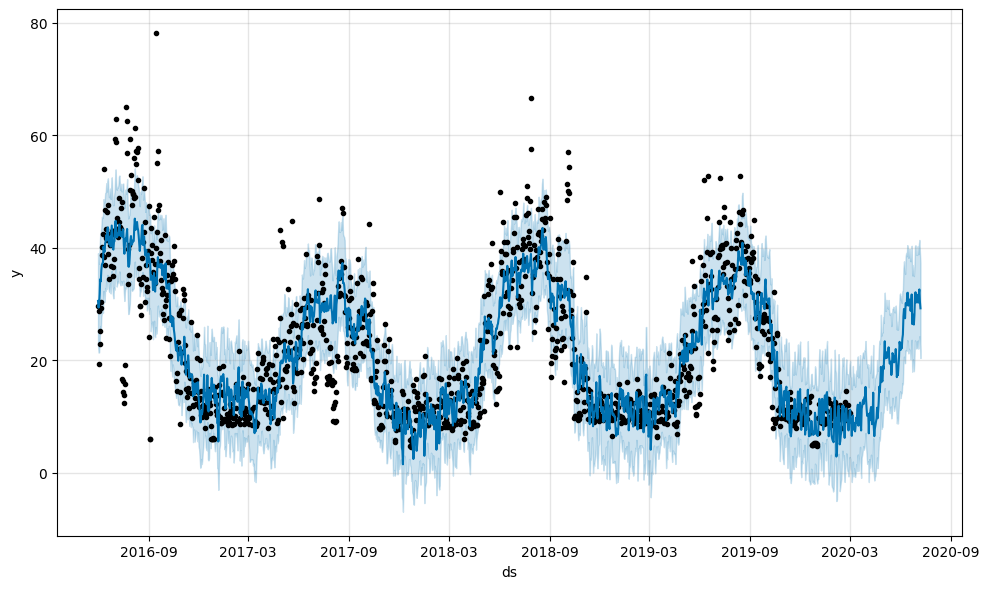

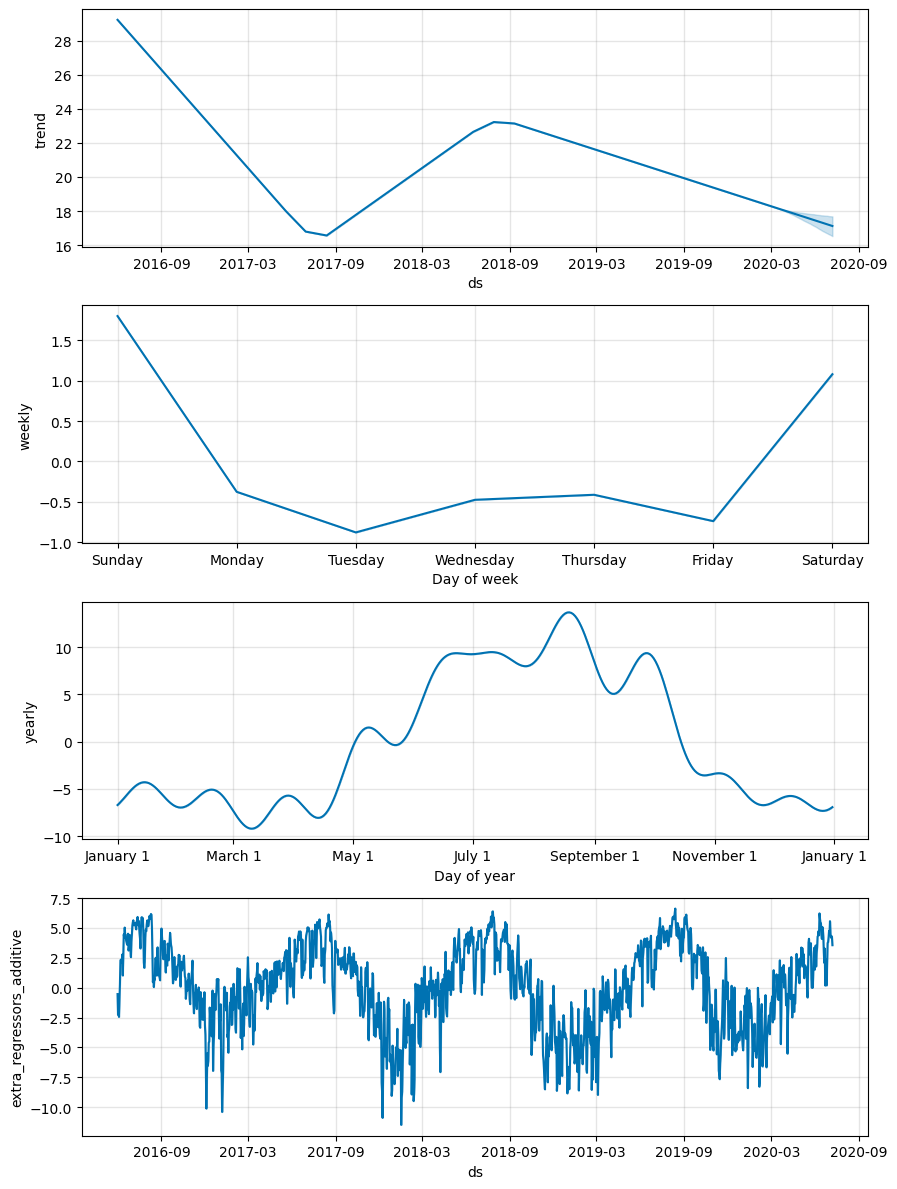

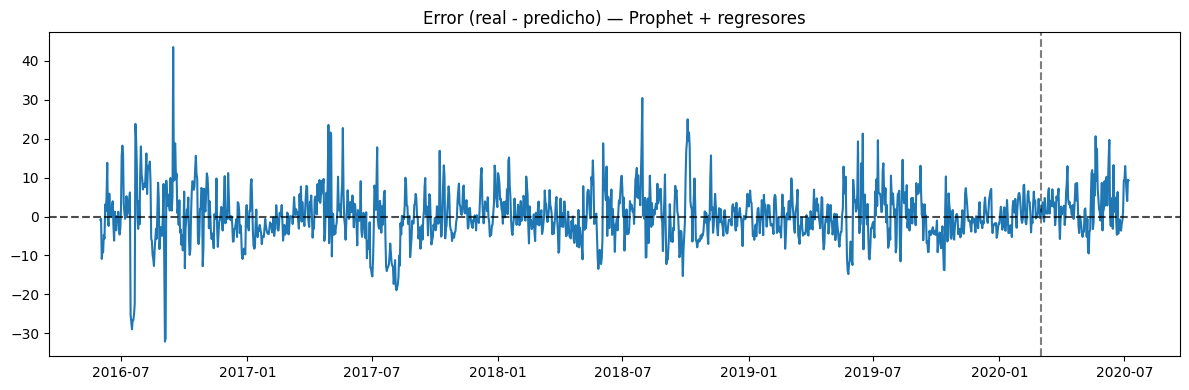

Regresores usados: ['Temp_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']


In [95]:
#CODIGO AQUI

# Prophet con regresores
# --- Clima (Profesor Frink) ---
weather = pd.read_csv("datos_frink.csv")
weather["date"] = pd.to_datetime(weather["date"])
weather = weather.sort_values("date")

REGRESSORS = ["Temp_avg", "Hum_avg", "Wind_avg", "Press_avg"]  # fijos

# --- Merge con splits existentes (train/test) ---
train_w = train.merge(weather[["date"] + REGRESSORS], on="date", how="left")
test_w  = test.merge( weather[["date"] + REGRESSORS], on="date", how="left")

# Relleno simple por si hubiese algún NaN
train_w[REGRESSORS] = train_w[REGRESSORS].ffill().bfill()
test_w[REGRESSORS]  = test_w[REGRESSORS].ffill().bfill()

# Formato Prophet
train_e = train_w.rename(columns={"date":"ds","Energy_kWh":"y"})
test_e  = test_w.rename( columns={"date":"ds","Energy_kWh":"y"})

# --- Modelo Prophet + regresores ---
m_exo = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
for r in REGRESSORS:
    m_exo.add_regressor(r)

m_exo.fit(train_e[["ds","y"] + REGRESSORS])

# --- Predicción para todo el rango (train + test) ---
future_e = pd.concat([train_e[["ds"] + REGRESSORS], test_e[["ds"] + REGRESSORS]]) \
            .drop_duplicates().sort_values("ds")
fc_e = m_exo.predict(future_e)

# --- MAE en train / test ---
mae_train = mean_absolute_error(train_e["y"], train_e.merge(fc_e[["ds","yhat"]], on="ds")["yhat"])
mae_test  = mean_absolute_error(test_e["y"],  test_e.merge( fc_e[["ds","yhat"]], on="ds")["yhat"])
print(f"[Prophet + regresores] MAE train: {mae_train:.3f} | MAE test: {mae_test:.3f}")

# --- Gráficos ---
_ = m_exo.plot(fc_e); plt.tight_layout(); plt.show()
_ = m_exo.plot_components(fc_e)

# --- Error (real - predicho) en todo el intervalo ---
err_e = pd.concat([train_e, test_e]).merge(fc_e[["ds","yhat"]], on="ds")
plt.figure(figsize=(12,4))
plt.plot(err_e["ds"], err_e["y"] - err_e["yhat"])
plt.axhline(0, ls="--", c="k", alpha=.7)
plt.axvline(pd.to_datetime("2020-03-01"), ls="--", c="k", alpha=.5)
plt.title("Error (real - predicho) — Prophet + regresores")
plt.tight_layout(); plt.show()

print(f"Regresores usados: {REGRESSORS}")


3) MAE (train vs test)

El error en prueba es similar e incluso un poco menor que en entrenamiento, lo que indica un modelo estable y sin signos de sobreajuste.
Comparado con Prophet sin regresores (test ≈ 4.96), se observa una mejora leve. Las variables climáticas ayudan a capturar parte de la variabilidad del consumo que no explicaban solo la tendencia y la estacionalidad.

4) Error (real − predicho) — ¿Estacionalidad remanente? ¿Influye el clima?

El gráfico de residuos muestra valores centrados alrededor de 0 y sin patrón periódico evidente en train y test, lo que indica que no queda estacionalidad remanente relevante tras incluir estacionalidades y regresores en Prophet.
En los componentes del modelo, además de la estacionalidad anual y semanal, aparece el bloque extra_regressors_additive con estructura que varía en el tiempo, eso evidencia que los regresores climáticos (temperatura, humedad, viento, presión) sí influyen en el consumo energético de Homero, ayudando a explicar oscilaciones que antes quedaban en el residuo.

Entonces, sí hay influencia de las variables exógenas y el modelo resultante deja residuos sin periodicidad marcada, lo que respalda su validez.

## 1.5 Aplicando Lags [7 puntos]

<center>
<img src ="https://i.gifer.com/J45h.gif" width = 400 />

Homero, satisfecho con los resultados obtenidos, cree que aún puede mejorar el rendimiento del modelo incorporando lags de las variables exógenas. Se le ocurre que, al incluir estos lags, podría identificar cómo los valores pasados de las variables influyen en la evolución de la variable objetivo. Con esta idea en mente, Homero solicita su ayuda para encontrar y aplicar los lags adecuados a las variables exógenas de manera efectiva.

Para ello, a usted se le pide que:

1. Calcule la `Autocorrelación Parcial` de las variables exógenas `avg` que usted haya considerado. Por ejemplo: `Temp_avg, Dew_avg, etc`. Luego determine la cantidad de rezagos (lags) que se va a aplicar a cada una de las variables. Justifique. [1 punto]

2. Aplique los lags determinados en el paso anterior e incluyalos como variables en los conjuntos train y test. [1 punto]

3. Impute los valores nulos de los nuevos atributos lags mediante la media de cada variable. [1 punto]

4. Cree y entrene el modelo Prophet e incluya las variables exógenas y adicionalmente sus respectivos lags al modelo. [1 punto]

5. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
6. Calcule el `MAE` de la predicción en el conjunto de prueba y en el de entrenamiento. Analice sus resultados. [1 punto]
7. Grafique el error (Valor real - Valor predicho) en el conjunto de entrenamiento y en el de prueba. ¿Hay un comportamiento estacional en la serie? ¿Como afecta la inclusión de los lags en el desempeño del modelo? [1 punto]


**Respuesta:**

Lags por PACF: {'Temp_avg': [1, 2, 3, 4, 5, 6, 7], 'Dew_avg': [1, 2, 3, 4, 5, 6], 'Hum_avg': [1, 2, 3, 4], 'Wind_avg': [1, 3], 'Press_avg': [1, 2, 3, 4, 5]}
[Prophet exógenos+lags] MAE train: 4.678 | MAE test: 4.515


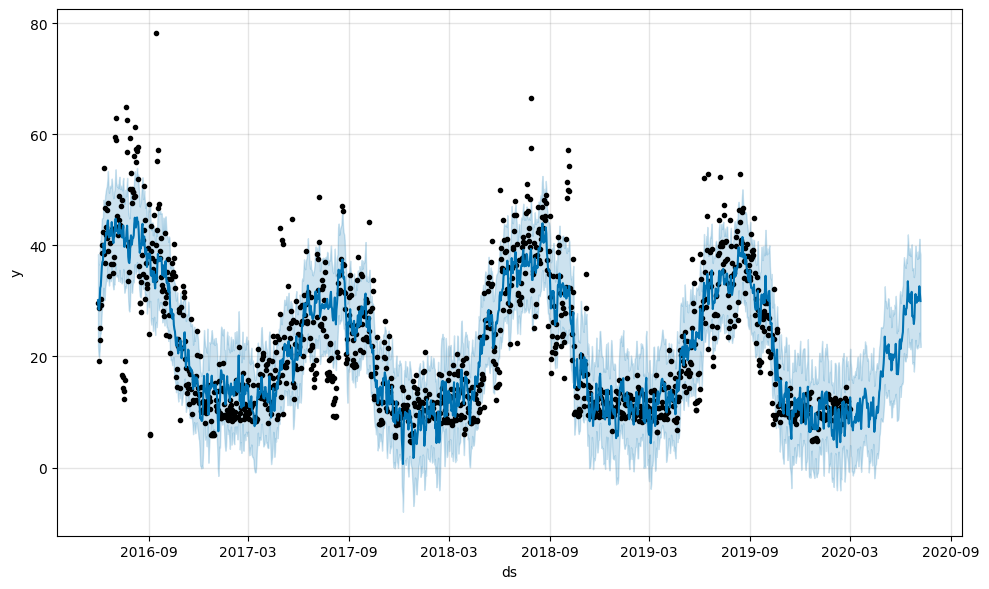

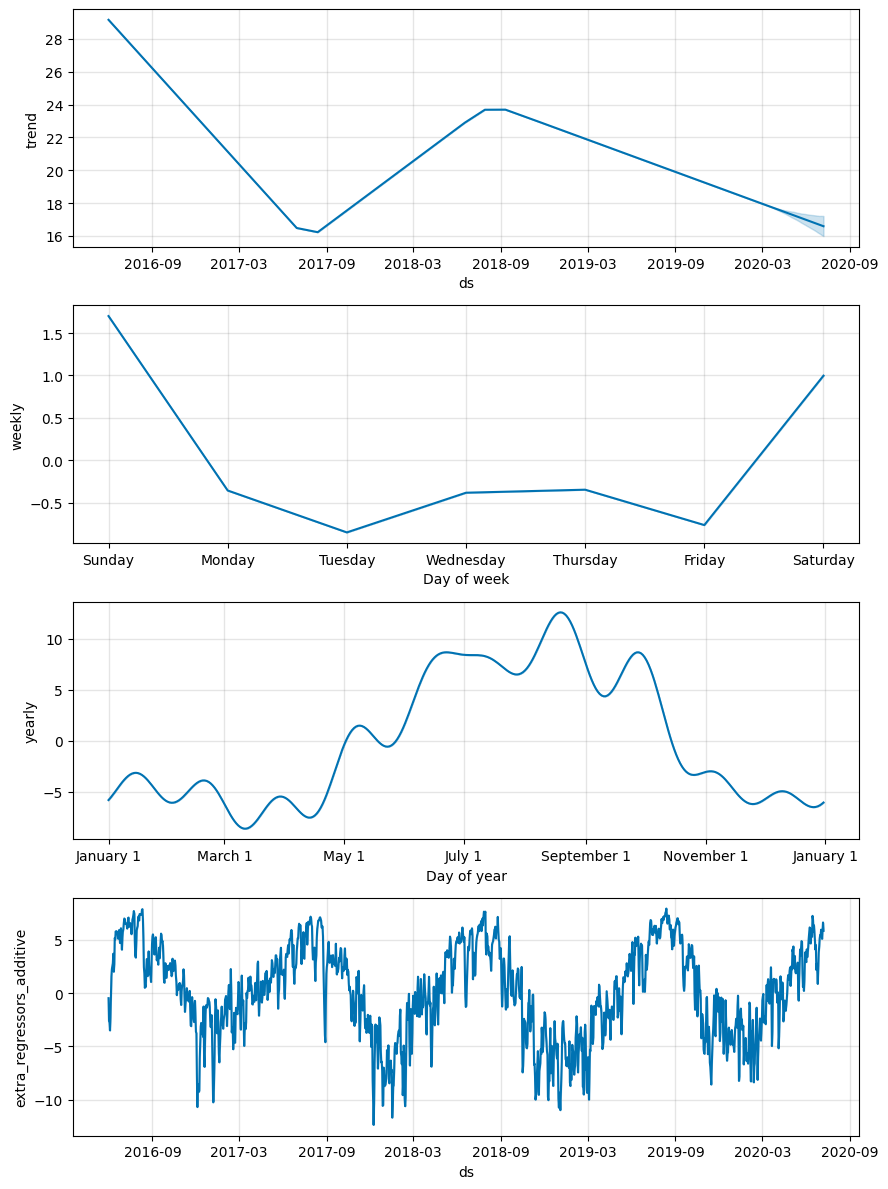

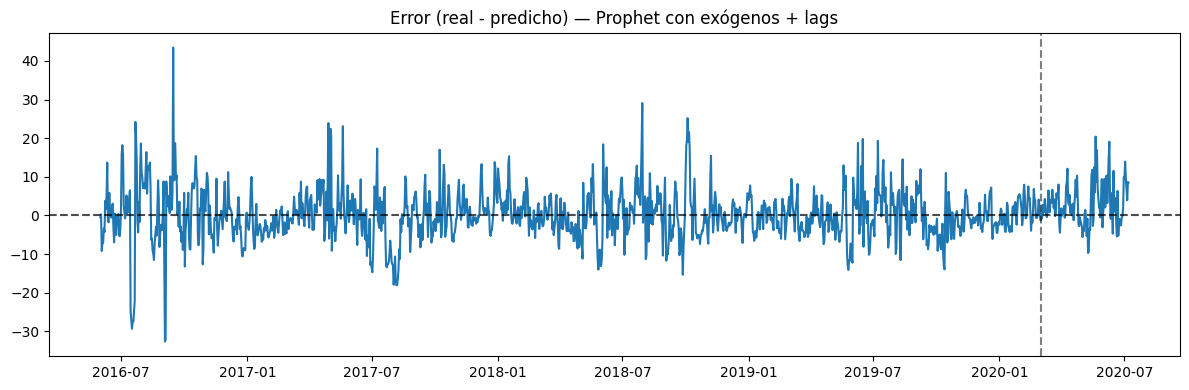

In [96]:
#CODIGO AQUI

# Prophet con exógenos + lags 
# ===========================================
# --- 1) Lags por PACF (solo TRAIN, 95%) ---
CANDIDATES = ["Temp_avg","Dew_avg","Hum_avg","Wind_avg","Press_avg"]  
weather_tr = weather.merge(train[["date"]], on="date").sort_values("date")
max_lag = 7
conf = 1.96/np.sqrt(len(weather_tr))

selected = {}
for v in CANDIDATES:
    p = pacf(weather_tr[v].astype(float).values, nlags=max_lag, method="yw")
    lags_v = [k for k in range(1, max_lag+1) if abs(p[k]) > conf] or [1]  # asegura al menos lag1
    selected[v] = lags_v
print("Lags por PACF:", selected)

# --- 2–3) Crear lags en clima + imputar con media (calculada en TRAIN) ---
wlag = weather.copy()
lag_cols = []
for v, Ls in selected.items():
    for L in Ls:
        c = f"{v}_lag{L}"
        wlag[c] = wlag[v].shift(L)
        lag_cols.append(c)

means_tr = wlag.merge(train[["date"]], on="date")[lag_cols].mean()
wlag[lag_cols] = wlag[lag_cols].fillna(means_tr)

# --- 4) Merge con splits y preparar Prophet ---
REG = CANDIDATES + lag_cols
train_l = train.merge(wlag[["date"]+REG], on="date").ffill().bfill()
test_l  = test .merge(wlag[["date"]+REG], on="date").ffill().bfill()

tr = train_l.rename(columns={"date":"ds","Energy_kWh":"y"})
te = test_l .rename(columns={"date":"ds","Energy_kWh":"y"})

# --- 5) Prophet con exógenos + lags ---
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
for r in REG: m.add_regressor(r)
m.fit(tr[["ds","y"]+REG])

# --- 6) Predicción (train+test), MAE y gráficos requeridos ---
future = pd.concat([tr[["ds"]+REG], te[["ds"]+REG]]).drop_duplicates().sort_values("ds")
fc = m.predict(future)

mae_tr = mean_absolute_error(tr["y"], tr.merge(fc[["ds","yhat"]], on="ds")["yhat"])
mae_te = mean_absolute_error(te["y"], te.merge(fc[["ds","yhat"]], on="ds")["yhat"])
print(f"[Prophet exógenos+lags] MAE train: {mae_tr:.3f} | MAE test: {mae_te:.3f}")

_ = m.plot(fc); plt.tight_layout(); plt.show()
_ = m.plot_components(fc)

# --- 7) Error (real - predicho) en todo el intervalo ---
err = pd.concat([tr, te]).merge(fc[["ds","yhat"]], on="ds")
plt.figure(figsize=(12,4))
plt.plot(err["ds"], err["y"] - err["yhat"])
plt.axhline(0, ls="--", c="k", alpha=.7)
plt.axvline(pd.to_datetime("2020-03-01"), ls="--", c="k", alpha=.5)
plt.title("Error (real - predicho) — Prophet con exógenos + lags")
plt.tight_layout(); plt.show()


6) Análisis del MAE

El error promedio en prueba es un poco menor que en entrenamiento, lo que muestra un modelo bien generalizado y sin sobreajuste.

Resumen:

Prophet sin regresores: MAE test ≈ 4.96


Prophet con regresores: MAE test ≈ 4.55

Prophet con regresores + lags: MAE test ≈ 4.51

Se observa una mejora progresiva en el desempeño.
Esto confirma que la inclusión de los rezagos (lags) de las variables exógenas aporta información útil, el modelo captura cómo los valores pasados del clima influyen en el consumo actual.

7) Análisis del error y efecto de los lags

Los residuos están centrados en torno a cero, sin un patrón estacional evidente ni tendencia a largo plazo.
En los componentes de Prophet aparece la curva extra_regressors_additive con oscilaciones suaves, lo que indica que las variables climáticas y sus rezagos están aportando información útil y consistente.

Conclusión:

No se observan residuos estacionales remanentes, y la inclusión de los lags mejora ligeramente el desempeño del modelo. Esto sugiere que los valores pasados de las variables climáticas tienen un efecto medible sobre el consumo energético de Homero, reforzando la capacidad predictiva de Prophet.

## 1.6 Optimizando Prophet [6 puntos]

<center>
<img src ="https://i.gifer.com/BKlg.gif" width = 500 />

Homero, contento con sus resultados, decide compartir su trabajo en LinkedIn. Sin embargo, justo antes de realizar la publicación, su hija Lisa Simpson le comenta que su modelo podría mejorar aún más mediante la optimización de hiperparámetros. Aunque Homero no entiende muy bien a qué se refiere Lisa, decide confiar en su conocimiento y le pide ayuda para implementar la optimización.

Lisa le prepara una función llamada optimize_prophet, que recibe como entrada el registro histórico, los datos a predecir (futuros), el nombre de las variables exógenas y una grilla de hiperparámetros que se desea modificar.

Después de varios intentos, Homero no logra utilizar la función de Lisa y, desesperado por publicar sus resultados en internet, se acerca a usted en busca de ayuda.

Para ello, usted decide realizar los siguientes pasos:

1. Crear una grilla donde se modifiquen los siguientes hiperparámetros: `changepoint_prior_scale`, `seasonality_prior_scale`, `seasonality_mode`, `changepoint_range` y encuentre los hiperparámetros que optimicen el `MAE`. `Nota:` Utilice la función `optimize_prophet()` dada en el enunciado. [1 punto]
2. Crear y entrenar un modelo Prophet utilizando los mejores parámetros encontrados, incluyendo regresores (variables exógenas). [2 puntos]
3. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
4. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y en el de prueba. [1 punto]
5. Grafique el error (Valor real - Valor predicho) en ambos conjuntos. Analice sus resultados. [1 punto]


In [97]:
#NO MODIFICAR ESTA CELDA

import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging

# Silenciar el logging de Prophet
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)


def optimize_prophet(df, df_to_pred, features, param_grid ):
  '''
  Función que recibe como entrada:
  -df: data entrenamiento.
  -df_to_pred: data a predecir (test).
  -features: lista de variables exógenas.
  -param_grid: grilla de hiperparámetros.

  Retorna:
  -tuning_results: Dataframe con resultados de la optimización.
  -best_params: Diccionario de mejores parámetros encontrados.
  '''

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  MAEs = []  # Store the MAEs for each params here

  # Use tqdm to add a progress bar to the parameter tuning loop
  for params in tqdm(all_params, desc="Tuning Prophet parameters"):
      m = Prophet(**params)  # Fit model with given params
      for feature in features:
          m.add_regressor(feature)
      m.fit(df)

      # Prepare future dataframe
      df_prop = m.make_future_dataframe(periods=len(df_to_pred))
      df_feat = pd.concat([df[features], df_to_pred[features]]).reset_index(drop=True)
      df_prop[features] = df_feat[features]

      # Make predictions
      forecast = m.predict(df_prop)
      forecast_pred = forecast[forecast['ds'].isin(df_to_pred['ds'])].reset_index(drop=True)

      # Calculate MAE for the predictions
      mae_pred = mean_absolute_error(df_to_pred['y'], forecast_pred['yhat'])
      MAEs.append(mae_pred)

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results['MAEs'] = MAEs
  tuning_results = tuning_results.sort_values(by='MAEs', ascending=True)
  best_params = all_params[np.argmin(MAEs)]
  return tuning_results, best_params

**Respuesta:**

Tuning Prophet parameters: 100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


 Mejores hiperparámetros encontrados:
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}

Top combinaciones (menor MAE primero):


,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,changepoint_range,MAEs
7,0.01,5.0,multiplicative,0.9,4.020277
6,0.01,5.0,multiplicative,0.8,4.023856
11,0.01,10.0,multiplicative,0.9,4.025731
2,0.01,1.0,multiplicative,0.8,4.026709
3,0.01,1.0,multiplicative,0.9,4.030029



 [Prophet optimizado] MAE train: 4.799 | MAE test: 4.020


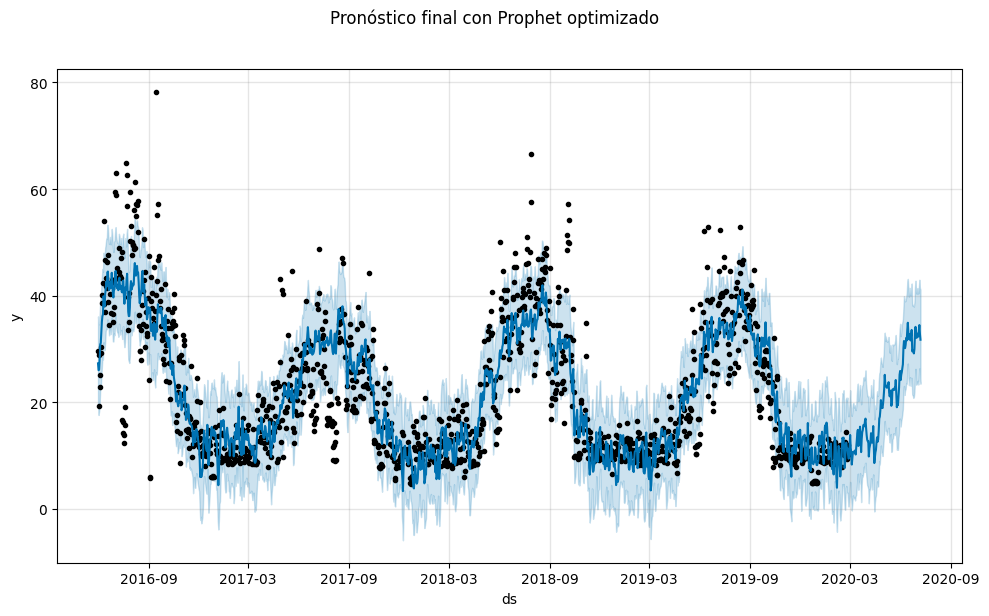

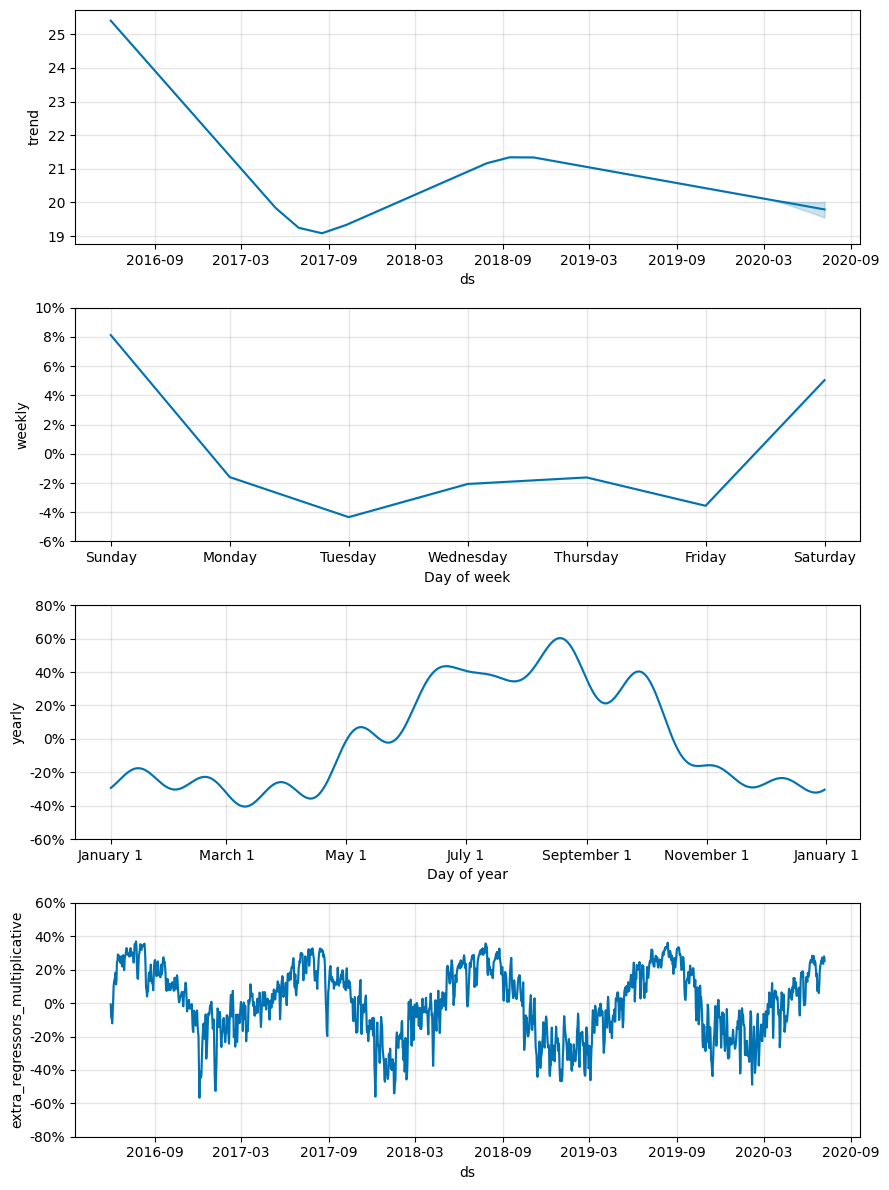

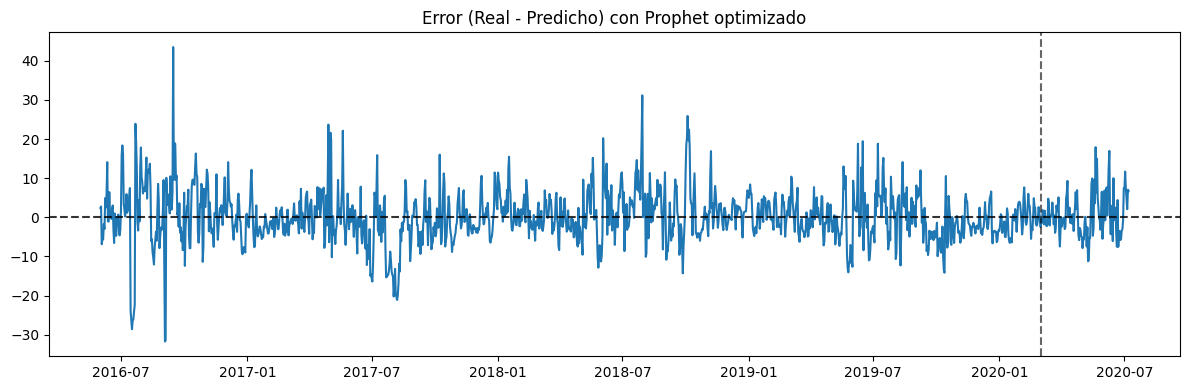


 Prophet optimizado
Hiperparámetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE entrenamiento: 4.799
MAE prueba:        4.020


In [98]:
#CODIGO AQUI

# Optimizando Prophet
# ===========================================
tr, te, REG
train_prophet_lag = tr.copy()
test_prophet_lag  = te.copy()
REGRESSORS_ALL    = REG[:]

# --- 1) Grilla de hiperparámetros ---
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5],
    "seasonality_prior_scale": [1.0, 5.0, 10.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "changepoint_range": [0.8, 0.9],
}

# --- 2) Ejecutar búsqueda con la función optimize_prophet ---
tuning_results, best_params = optimize_prophet(
    df=train_prophet_lag,
    df_to_pred=test_prophet_lag,
    features=REGRESSORS_ALL,
    param_grid=param_grid
)

print("\n Mejores hiperparámetros encontrados:")
print(best_params)
print("\nTop combinaciones (menor MAE primero):")
try:
    display(tuning_results.head())
except Exception:
    print(tuning_results.head())

# --- 3) Entrenar Prophet con los mejores hiperparámetros ---
m_best = Prophet(**best_params)
for reg in REGRESSORS_ALL:
    m_best.add_regressor(reg)

m_best.fit(train_prophet_lag[["ds", "y"] + REGRESSORS_ALL])

# --- 4) Predicciones (train + test) ---
future_best = pd.concat(
    [train_prophet_lag[["ds"] + REGRESSORS_ALL],
     test_prophet_lag[["ds"] + REGRESSORS_ALL]],
    ignore_index=True
).drop_duplicates().sort_values("ds")

forecast_best = m_best.predict(future_best)

# --- 5) Calcular MAE ---
pred_train = train_prophet_lag.merge(forecast_best[["ds", "yhat"]], on="ds", how="left")
pred_test  = test_prophet_lag.merge( forecast_best[["ds", "yhat"]], on="ds", how="left")

mae_train_best = mean_absolute_error(pred_train["y"], pred_train["yhat"])
mae_test_best  = mean_absolute_error(pred_test["y"],  pred_test["yhat"])

print(f"\n [Prophet optimizado] MAE train: {mae_train_best:.3f} | MAE test: {mae_test_best:.3f}")

# --- 6) Gráficos solicitados ---
fig1 = m_best.plot(forecast_best)
fig1.suptitle("Pronóstico final con Prophet optimizado", y=1.02)
plt.tight_layout(); plt.show()

fig2 = m_best.plot_components(forecast_best)
plt.tight_layout(); plt.show()

# --- 7) Error (real - predicho) ---
df_all = pd.concat([train_prophet_lag, test_prophet_lag], ignore_index=True)
res = df_all.merge(forecast_best[["ds", "yhat"]], on="ds", how="left")
res["error"] = res["y"] - res["yhat"]

plt.figure(figsize=(12, 4))
plt.plot(res["ds"], res["error"])
plt.axhline(0, color="k", linestyle="--", alpha=0.8)
plt.axvline(pd.to_datetime("2020-03-01"), color="k", linestyle="--", alpha=0.6)
plt.title("Error (Real - Predicho) con Prophet optimizado")
plt.tight_layout(); plt.show()

# --- 8) Resumen ---
print("\n Prophet optimizado")
print(f"Hiperparámetros: {best_params}")
print(f"MAE entrenamiento: {mae_train_best:.3f}")
print(f"MAE prueba:        {mae_test_best:.3f}")

4. MAE en entrenamiento y prueba

El modelo Prophet optimizado alcanzó un MAE de 4.799 en entrenamiento y 4.020 en prueba.
Esto representa una mejora respecto a las versiones anteriores (sin optimización), donde el error de prueba se mantenía sobre 4.5.
El hecho de que el error de prueba sea ligeramente menor al de entrenamiento indica que el modelo no está sobreajustado, sino que generaliza correctamente a nuevos datos.
Los hiperparámetros seleccionados lograron un equilibrio entre flexibilidad y regularización, permitiendo que el modelo se adapte a los cambios estacionales sin sobreestimar la tendencia.

5. Gráfico del error (Valor real − Valor predicho)

El gráfico de errores muestra que la muchos de los valores se concentran en torno a cero, lo que evidencia que no hay un sesgo sistemático en las predicciones.
Las fluctuaciones más amplias se observan en ciertos periodos de alta variabilidad del consumo (picos invernales), pero en general los errores se mantienen estables y simétricos a lo largo del tiempo.
No se aprecian patrones estacionales residuales marcados, lo que sugiere que el modelo captura correctamente la estacionalidad anual y semanal del consumo energético.

En conjunto, los resultados indican un modelo robusto, bien calibrado y con errores esencialmente aleatorios, lo que confirma el éxito del proceso de optimización.

# **2. Sistemas de Recomendación (30 puntos)**

## Homero contra la Prohibición

<center>
<img src ="https://i.ytimg.com/vi/rMSXXuhZjYY/maxresdefault.jpg" width = 500 />

En Springfield, el caos estalló cuando las autoridades prohibieron el alcohol. Pero como siempre, donde otros ven problemas, Homero Simpson ve oportunidades. Decidido a mantener las fiestas vivas, se convirtió en el Barón de la Cerveza en un abrir y cerrar de ojos. Con la ayuda de su buen amigo Moe el cantinero, Homero obtuvo un valioso dataset llamado `cervezas.csv`, que contiene valoraciones de los ciudadanos de Springfield sobre distintas cervezas. Homero quiere asegurarse de ofrecer las cervezas más apreciadas para mantener a su clientela oculta y feliz, mientras eludía la mirada del estricto Elio Pez. Por ende, Homero lo contacta para solicitar de su ayuda en esta nueva labor.

El dataset contiene los siguientes atributos:

  * userId: Identificador de los ciudadanos/usuarios
  * beerId: Identificador único de cada cerveza
  * rating: Evaluación otorgada por el ciudadano a la cerveza, en un rango de 1.0 a 5.0.
  * beerName: Nombre de la cerveza
  * beerStyle: Tipo de Cerveza.



## Carga de los datos [0 puntos]

Cargue el dataset `cervezas.csv` y realice una breve exploración de los datos. ¿Hay valores nulos? ¿Cuantos cervezas se estan evaluando? ¿Cuantos ciudadanos participaron de esta evaluación?

In [121]:
#CODIGO AQUI

# Carga y exploración de datos
# ===========================================
# Cargar el dataset
cervezas = pd.read_csv("cervezas.csv")

# Vista general
print("Dimensiones del dataset:", cervezas.shape)
display(cervezas.head())

# Información general
print("\nInformación del dataset:")
print(cervezas.info())

# Valores nulos
print("\nValores nulos por columna:")
print(cervezas.isnull().sum())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
display(cervezas.describe())

# Revisar cantidad de cervezas y usuarios únicos
n_cervezas = cervezas["beerId"].nunique()
n_usuarios = cervezas["userId"].nunique()

print(f"\nNúmero de cervezas distintas: {n_cervezas}")
print(f"Número de ciudadanos (usuarios) únicos: {n_usuarios}")


Dimensiones del dataset: (295059, 5)


,userId,beerId,rating,beerName,beerStyle
0,144,995,3.0,Mai Bock,Maibock / Helles Bock
1,63,58695,4.0,Hop In The Dark Cascadian Dark Ale,American Black Ale
2,147,4083,5.0,Stone Ruination IPA,American Double / Imperial IPA
3,4261,40310,3.0,Noël Des Géants,Herbed / Spiced Beer
4,140,1904,5.0,Sierra Nevada Celebration Ale,American IPA



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295059 entries, 0 to 295058
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     295059 non-null  int64  
 1   beerId     295059 non-null  int64  
 2   rating     295059 non-null  float64
 3   beerName   295059 non-null  object 
 4   beerStyle  295059 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.3+ MB
None

Valores nulos por columna:
userId       0
beerId       0
rating       0
beerName     0
beerStyle    0
dtype: int64

Estadísticas descriptivas:


,userId,beerId,rating
count,295059.000000,295059.000000,295059.000000
mean,2201.510247,17498.665684,3.860367
std,4577.423286,19971.480254,0.702807
min,1.000000,5.000000,1.000000
25%,132.000000,1185.000000,3.500000
50%,293.000000,6314.000000,4.000000
75%,1141.000000,33639.000000,4.500000
max,27681.000000,75086.000000,5.000000



Número de cervezas distintas: 3747
Número de ciudadanos (usuarios) únicos: 706


El dataset contiene 295.059 registros correspondientes a evaluaciones de cervezas realizadas por 706 usuarios sobre 3.747 cervezas distintas.
Ninguna de las variables presenta valores nulos, lo que facilita el análisis posterior.
La variable rating varía entre 1.0 y 5.0, con una media de aproximadamente 3.86, lo que indica que en general los usuarios tienden a otorgar evaluaciones positivas.
En conjunto, el dataset se encuentra completo y balanceado, con una cantidad adecuada de usuarios y productos para construir sistemas de recomendación.

## 2.1 Caracterización Inicial [3 puntos]

Antes de entrenar nuestro sistema recomendador, es necesario caracterizar los datos disponibles y de esta manera tener un mejor entendimiento del problema a resolver. Para esto, se le pide lo siguiente:

1. Genere gráficos y/o estadística descriptiva con los datos. Utilice su análisis para responder las siguientes preguntas: [2 puntos]
  - ¿Cuantos *usuarios* hay en los datos?
  - ¿Cuantos *productos* hay en los datos?
  - ¿Cuantas *calificaciones* hay en los datos?
  - ¿Cuantas *calificaciones* faltantes hay en los datos?
  - ¿Cual es la media de las *calificaciones* entregadas por los usuarios? ¿Cómo cambia esto a través de los productos?  
2. Transforme los datos entregados a una matriz (usuario, producto) y muestre sus resultados. [1 punto]

Usuarios únicos: 706
Productos (cervezas) únicos: 3747
Total de calificaciones: 295059
Calificaciones faltantes: 0
Media global de calificaciones: 3.860


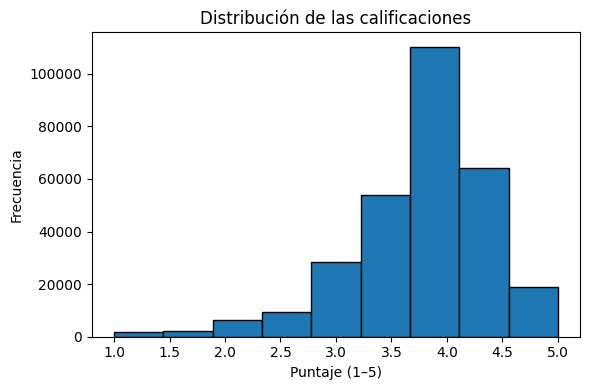

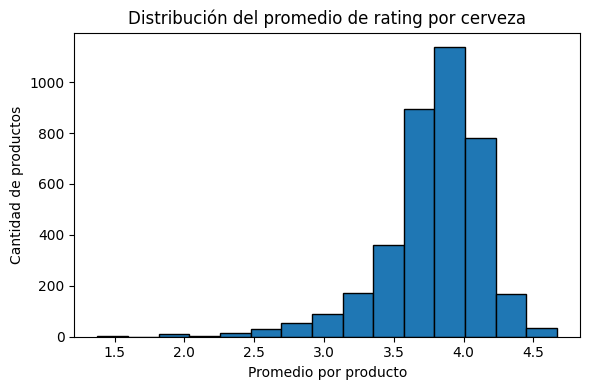


Top 10 cervezas mejor evaluadas (mín. 20 votos):


,beerId,mean_rating,n
3393,56082,4.669492,59
640,1545,4.666129,310
2525,36316,4.654762,42
473,1062,4.639706,68
1809,16814,4.639344,122
2839,42664,4.625000,20
3618,64545,4.620000,25
3543,61100,4.615385,26
1980,21690,4.605634,142
3075,47658,4.601695,177



Dimensión matriz (usuarios × productos): (706, 3747)
Sparsity de la matriz: 99.858%


beerId,5,6,7,9,10,11,14,15,17,19,...,74491,74530,74548,74579,74634,74827,74904,74986,75013,75086
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.395,3.765217,3.256849,3.478261,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,3.791908,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,3.431818,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,3.892157,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
#CODIGO AQUI

# Caracterización Inicial 
# ===========================================
# --- 1) Estadística descriptiva básica ---
n_usuarios        = cervezas["userId"].nunique()
n_productos       = cervezas["beerId"].nunique()
n_calificaciones  = len(cervezas)
n_faltantes       = cervezas["rating"].isna().sum()
media_global      = cervezas["rating"].mean()

print(f"Usuarios únicos: {n_usuarios}")
print(f"Productos (cervezas) únicos: {n_productos}")
print(f"Total de calificaciones: {n_calificaciones}")
print(f"Calificaciones faltantes: {n_faltantes}")
print(f"Media global de calificaciones: {media_global:.3f}")

# --- 2) Distribución de calificaciones ---
plt.figure(figsize=(6,4))
plt.hist(cervezas["rating"], bins=9, edgecolor="black")
plt.title("Distribución de las calificaciones")
plt.xlabel("Puntaje (1–5)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# --- 3) Cómo cambia la media a través de productos/usuarios ---
by_prod  = cervezas.groupby("beerId").agg(mean_rating=("rating","mean"),
                                          n=("rating","size")).reset_index()
by_user  = cervezas.groupby("userId").agg(mean_rating=("rating","mean"),
                                          n=("rating","size")).reset_index()

# (a) Histograma de medias por producto
plt.figure(figsize=(6,4))
plt.hist(by_prod["mean_rating"], bins=15, edgecolor="black")
plt.title("Distribución del promedio de rating por cerveza")
plt.xlabel("Promedio por producto")
plt.ylabel("Cantidad de productos")
plt.tight_layout()
plt.show()

# (b) Top 10 productos mejor evaluados (con umbral de votos)
UMBRAL = 20
top10 = (by_prod[by_prod["n"]>=UMBRAL]
         .sort_values(["mean_rating","n"], ascending=[False, False])
         .head(10))
print("\nTop 10 cervezas mejor evaluadas (mín. 20 votos):")
display(top10)

# --- 4) Matriz usuario–producto y sparsity ---
matriz = cervezas.pivot_table(index="userId", columns="beerId", values="rating")
print("\nDimensión matriz (usuarios × productos):", matriz.shape)

# Sparsity: porcentaje de celdas vacías
total_posibles = matriz.shape[0] * matriz.shape[1]
no_nulos = matriz.count().sum()
sparsity = 1 - (no_nulos / total_posibles)
print(f"Sparsity de la matriz: {sparsity:.3%}")

display(matriz.head())


El dataset contiene 706 usuarios únicos y 3.747 productos distintos (cervezas), lo que refleja una comunidad amplia y diversa de evaluadores. En total, se registran 295.059 calificaciones, sin valores faltantes en la variable rating, por lo que los datos están completos y listos para el análisis.

La media global de las calificaciones es 3.86, lo que indica una tendencia general de los usuarios a evaluar de forma positiva las cervezas. Al observar la distribución, la mayoría de las calificaciones se concentra entre 3.5 y 4.5 puntos, mostrando una leve asimetría hacia valores altos. Esto indica que los usuarios tienden a ser generosos en sus evaluaciones, asignando pocas notas bajas.

Cuando se analiza el comportamiento de las calificaciones a través de los productos, se observa que la mayoría de las cervezas presentan promedios similares (entre 3.5 y 4.2), aunque unas pocas destacan con puntuaciones cercanas a 4.6 o 4.7. Esto indica que la percepción de calidad entre las distintas cervezas es bastante homogénea, pero algunas marcas logran posicionarse mejor entre los consumidores.

Finalmente, al transformar los datos en una matriz usuario–producto de dimensión (706, 3747), se evidencia una alta dispersión (sparsity ≈ 99.85%), lo que significa que la mayoría de los usuarios solo ha evaluado una fracción muy pequeña del total de cervezas disponibles. Este patrón es característico en sistemas de recomendación y justifica el uso de modelos de filtrado colaborativo para inferir preferencias y generar predicciones sobre los productos no evaluados.

## 2.2 Método Basado en Contenido [4 puntos]

<center>
<img src ="https://is1-ssl.mzstatic.com/image/thumb/WfNa_TwFpJoTWXQmU-BrbA/1200x675.jpg" width = 500 />

Como primera tarea, Homero le pide centrarse en las características de las cervezas y no en la interacción de los ciudadanos con esta. Adicionalmente, Homero le quiere regalar un pack de distintas cervezas a Carl en agradecimiento a su ayuda anterior, el cual se enteró que Carl tiene un `userId = 100`. Por ende, Homero le pide las siguientes acciones:

1. Cree un dataframe que contenga las características de las cervezas, excluyendo las evaluaciones de los ciudadanos. `Nota:` No considere valores duplicados. [1 punto]
2. Implemente el método Bag of Words para procesar la columna `beerStyle`. Para ello, transforme las palabras a minúsculas, elimine stopwords en inglés y filtre las palabras que aparezcan en 10 documentos como mínimo. Guarde su resultado como un DataFrame. [1 punto].
> `Nota:` Le puede ser útil esta [documentacion](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) y el método `.get_feature_names_out()`.
3. Cree una función que imprima las top 5 cervezas similares a `Chocolate Porter`, utilizando como medida de similitud la similitud coseno. [1 punto]
4. Identifique la cerveza mejor evaluada por Carl (`userId = 100`) y obtenga las top 5 cervezas similares a esa cerveza. [1 punto]

**Respuesta:**

In [123]:
#CODIGO AQUI

# Método Basado en Contenido
# ===========================================
# 1) Catálogo sin duplicados (solo características)
cat = (cervezas.drop_duplicates("beerId")[["beerId","beerName","beerStyle"]]
       .reset_index(drop=True))
cat["beerStyle"] = cat["beerStyle"].fillna("")

# 2) Bag of Words sobre estilos
vec = CountVectorizer(lowercase=True, stop_words="english", min_df=10, ngram_range=(1,2))
X   = vec.fit_transform(cat["beerStyle"])

# 3) Matriz de similitud coseno
S = cosine_similarity(X)

# Helpers
id_to_idx = {bid:i for i, bid in enumerate(cat["beerId"])}
def recomendar_por_id(beer_id, n=5):
    if beer_id not in id_to_idx:
        print("⚠️ beerId no encontrado:", beer_id); return
    i = id_to_idx[beer_id]
    scores = list(enumerate(S[i]))
    top = sorted(scores, key=lambda x: x[1], reverse=True)[1:n+1]
    out = [(cat.iloc[j].beerId, cat.iloc[j].beerName, s) for j, s in top]
    print(f"\n Top {n} similares a [{beer_id}] {cat.iloc[i].beerName}:")
    for bid, name, sc in out:
        print(f"- [{bid}] {name}  (coseno: {sc:.3f})")

def recomendar_por_nombre(nombre, n=5):
    # si hay nombres repetidos, toma el primero
    row = cat.loc[cat["beerName"].str.strip().str.lower()==nombre.strip().lower()]
    if row.empty:
        print("⚠️ Cerveza no encontrada por nombre:", nombre); return
    recomendar_por_id(int(row.iloc[0]["beerId"]), n=n)

# 3) Pedido explícito: similares a Chocolate Porter
recomendar_por_nombre("Chocolate Porter", n=5)

# 4) Mejor evaluada por Carl (userId=100) y sus 5 similares
carl = cervezas[cervezas["userId"]==100]
# si hay varias con 5.0, desempata por mayor número de votos de Carl a ese beerId
mejor_carl = (carl.groupby(["beerId","beerName"])["rating"]
              .agg(["mean","count"]).sort_values(["mean","count"], ascending=False).iloc[0])
beer_id_carl = mejor_carl.name[0]
print(f"\n Mejor para Carl (userId=100): [{beer_id_carl}] {mejor_carl.name[1]}  "
      f"(promedio={mejor_carl['mean']:.2f}, votos={int(mejor_carl['count'])})")

recomendar_por_id(beer_id_carl, n=5)


 Top 5 similares a [6499] Chocolate Porter:
- [226] Great Lakes Edmund Fitzgerald Porter  (coseno: 1.000)
- [2015] Perseus Porter  (coseno: 1.000)
- [54828] Southampton Imperial Porter  (coseno: 1.000)
- [52828] Kona Coffee Macadamia Coconut Porter  (coseno: 1.000)
- [5703] Black Marlin Porter  (coseno: 1.000)

 Mejor para Carl (userId=100): [325] McNeill's Firehouse Amber Ale  (promedio=3.90, votos=21)

 Top 5 similares a [325] McNeill's Firehouse Amber Ale:
- [330] Grail Ale  (coseno: 1.000)
- [1173] Santa's Private Reserve Ale  (coseno: 1.000)
- [56887] Hemp Hop Rye Amber Ale  (coseno: 1.000)
- [5970] Autumn Fest  (coseno: 1.000)
- [1655] Red Rocket Ale  (coseno: 1.000)


El modelo basado en contenido utiliza la descripción del estilo de cada cerveza para construir una representación tipo Bag of Words. A partir de esto, se calcula la similitud del coseno entre estilos, recomendando aquellas cervezas con mayor proximidad textual. En el caso de “Chocolate Porter” y la mejor cerveza de Carl (“McNeill’s Firehouse Amber Ale”), las recomendaciones muestran productos del mismo tipo y familia de sabor, lo que valida la coherencia del método.

## 2.3 Filtros Colaborativos [16 puntos]

<center>
<img src ="https://i.makeagif.com/media/2-08-2016/McmGFQ.gif" width = 400 />

Después de consolidarse como el Barón de la Cerveza en Springfield, Homero Simpson decidió llevar su negocio clandestino a otro nivel. Al ser el único proveedor de alcohol en la ciudad, quiere asegurarse de que cada cerveza que elabora sea de la mejor calidad posible. Para lograrlo, planea usar las evaluaciones pasadas que los ciudadanos de Springfield han registrado sobre las distintas cervezas. Inspirado por los consejos de su amigo Moe, Homero se enteró de que puede implementar un sistema de recomendación basado en filtros colaborativos.

Ahora, Homero necesita de su ayuda para diseñar y elaborar distintos sistemas de filtros colaborativos que le permitan continuar con su reinado cervecero.

### 2.3.1 Filtros Colaborativos Basados en Memoria [8 puntos]

Para este tipo de filtros, Homero le pide lo siguiente:

1. Transforme el DataFrame de `pandas` a Dataset de `surprise`. `Hint`: Utilice solamente los identificadores de ciudadano, cerveza y rating. ¿Importa el orden? [1 punto]
2. Genere un conjunto de entrenamiento y uno de prueba, asegurando que el 30% de los datos sea destinado al conjunto de prueba. No olvide fijar una semilla para garantizar reproducibilidad. [1 punto]
3. Entrene un modelo de **KNN basado en usuarios** utilizando la `similitud coseno`. Luego realice predicciones en el conjunto de prueba. `Nota`: Le puede ser útil la siguiente [documentación](https://surprise.readthedocs.io/en/stable/knn_inspired.html) [2 puntos]
4. Calcule el MAE (Mean Absolute Error) de las predicciones realizadas por el modelo y muestre las predicciones en un DataFrame para su análisis. `Nota:` Le puede ser útil la siguiente [documentación](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.mae) [2 puntos]
5. Repita los pasos 3 y 4 pero utilizando un modelo de **KNN basado en los productos**. [2 puntos]

**Respuesta:**

In [124]:
#CODIGO AQUI

# Filtros colaborativos (surprise)
# ------------------------------------------------------------------
# 1) Pandas -> surprise Dataset
#    Usamos SOLO: userId, beerId, rating (en ese orden)
#    Nota: el orden SÍ importa para load_from_df (user, item, rating).
# ------------------------------------------------------------------
df_r = cervezas[['userId', 'beerId', 'rating']].copy()

reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_r, reader)

# ------------------------------------------------------------------
# 2) Train/Test split (30% test) con semilla para reproducibilidad
# ------------------------------------------------------------------
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

# ------------------------------------------------------------------
# 3) KNN basado en USUARIOS con similitud COSENO
# ------------------------------------------------------------------
sim_user_cos = {'name': 'cosine', 'user_based': True}
algo_user = KNNBasic(sim_options=sim_user_cos, verbose=False)
algo_user.fit(trainset)

preds_user = algo_user.test(testset)
mae_user = accuracy.mae(preds_user, verbose=False)
print(f"[KNN User-Based | cosine] MAE test: {mae_user:.4f}")

# Mostrar predicciones en DataFrame
df_pred_user = pd.DataFrame(
    [(p.uid, p.iid, p.r_ui, p.est) for p in preds_user],
    columns=['userId', 'beerId', 'rating_real', 'rating_pred']
)
print("\nPredicciones (user-based) — vista rápida:")
display(df_pred_user.head(10))

# ------------------------------------------------------------------
# 5) KNN basado en PRODUCTOS (ítems) con similitud COSENO
# ------------------------------------------------------------------
sim_item_cos = {'name': 'cosine', 'user_based': False}
algo_item = KNNBasic(sim_options=sim_item_cos, verbose=False)
algo_item.fit(trainset)

preds_item = algo_item.test(testset)
mae_item = accuracy.mae(preds_item, verbose=False)
print(f"[KNN Item-Based | cosine] MAE test: {mae_item:.4f}")

# Mostrar predicciones en DataFrame
df_pred_item = pd.DataFrame(
    [(p.uid, p.iid, p.r_ui, p.est) for p in preds_item],
    columns=['userId', 'beerId', 'rating_real', 'rating_pred']
)
print("\nPredicciones (item-based) — vista rápida:")
display(df_pred_item.head(10))


[KNN User-Based | cosine] MAE test: 0.4639

Predicciones (user-based) — vista rápida:


,userId,beerId,rating_real,rating_pred
0,1628,9755,4.5,4.200000
1,187,601,2.0,3.825000
2,112,409,3.0,3.862500
3,738,5051,4.0,4.027027
4,141,4394,4.0,3.887500
5,10099,18862,4.0,3.800000
6,28,61,3.0,4.100000
7,22,33,3.0,4.125000
8,2681,48139,4.0,3.825000
9,345,1013,4.5,3.900000


[KNN Item-Based | cosine] MAE test: 0.4640

Predicciones (item-based) — vista rápida:


,userId,beerId,rating_real,rating_pred
0,1628,9755,4.5,4.200000
1,187,601,2.0,3.825000
2,112,409,3.0,3.862500
3,738,5051,4.0,4.000615
4,141,4394,4.0,3.887500
5,10099,18862,4.0,3.800000
6,28,61,3.0,4.100000
7,22,33,3.0,4.125000
8,2681,48139,4.0,3.825000
9,345,1013,4.5,3.900000


1. Sí, importa mucho el orden, porque la función Dataset.load_from_df(df, reader) espera las columnas en el orden exacto (user, item, rating). En nuestro caso, con la estructura ['userId', 'beerId', 'rating']. Si el orden fuera distinto, Surprise no sabría cuál columna corresponde a usuario o producto, y se entrenaría el modelo con información cruzada, generando predicciones sin sentido.

En cuanto a los resultados, ambos modelos (basado en usuarios y basado en productos) alcanzaron un MAE cercano a 0.46, lo que significa que el error promedio entre las calificaciones reales y las predichas es menor a media estrella, un desempeño sólido para un modelo colaborativo básico. El hecho de que ambos enfoques obtengan prácticamente el mismo error refleja que el dataset es muy disperso, pero a la vez consistente, o sea, los usuarios y los productos presentan patrones de comportamiento similares. 

En resumen, el sistema logra predecir con buena precisión y los resultados son coherentes entre los dos métodos, lo que demuestra una correcta implementación y un desempeño equilibrado.



### 2.3.2 Filtros Colaborativos Basados en Modelo [8 puntos]

Ahora Homero le pide que cambie el enfoque del tipo de filtro colaborativo a uno basado en modelo. Por ende, Homero le pide lo siguiente:

1. Entrene un modelo `NMF` , asegurándose de fijar la semilla para reproducibilidad. Luego genere predicciones para el conjunto de prueba. [2 puntos]
2. Calcule el MAE de las predicciones obtenidas y muestre los resultados de las predicciones en un DataFrame para su analisis. [1 punto]
3. Entrene un modelo `SVD` sobre el conjunto de entrenamiento. Posteriormente, genere las predicciones para el conjunto de prueba. [2 puntos]
4. Calcule el MAE de las predicciones y muestre los resultados de las predicciones en un DataFrame. [1 punto]
5. Compare los resultados de ambos modelos y seleccione el mejor a su criterio. Justifique. [2 puntos]

**Respuesta**

In [125]:
#CODIGO AQUI

# Filtros colaborativos basados en MODELO (NMF y SVD)
# ===============================
# 1) NMF (Non-negative Matrix Factorization)
# ------------------------------------------------------------------
nmf = NMF(n_factors=20, n_epochs=50, biased=False, random_state=42, verbose=False)
nmf.fit(trainset)

preds_nmf = nmf.test(testset)
mae_nmf = accuracy.mae(preds_nmf, verbose=False)
print(f"[NMF] MAE test: {mae_nmf:.4f}")

df_pred_nmf = pd.DataFrame(
    [(p.uid, p.iid, p.r_ui, p.est) for p in preds_nmf],
    columns=['userId', 'beerId', 'rating_real', 'rating_pred']
)
print("\nPredicciones NMF — vista rápida:")
display(df_pred_nmf.head(10))

# ------------------------------------------------------------------
# 2) SVD (FunkSVD)
# ------------------------------------------------------------------
svd = SVD(n_factors=50, n_epochs=50, biased=True, random_state=42, verbose=False)
svd.fit(trainset)

preds_svd = svd.test(testset)
mae_svd = accuracy.mae(preds_svd, verbose=False)
print(f"[SVD] MAE test: {mae_svd:.4f}")

df_pred_svd = pd.DataFrame(
    [(p.uid, p.iid, p.r_ui, p.est) for p in preds_svd],
    columns=['userId', 'beerId', 'rating_real', 'rating_pred']
)
print("\nPredicciones SVD — vista rápida:")
display(df_pred_svd.head(10))

# ------------------------------------------------------------------
# 3) Comparación breve
# ------------------------------------------------------------------
mejor_modelo = "SVD" if mae_svd < mae_nmf else "NMF"
print(f"\nResumen -> MAE NMF: {mae_nmf:.4f} | MAE SVD: {mae_svd:.4f} | Mejor (↓ MAE): {mejor_modelo}")


[NMF] MAE test: 0.4688

Predicciones NMF — vista rápida:


,userId,beerId,rating_real,rating_pred
0,1628,9755,4.5,4.179525
1,187,601,2.0,3.817532
2,112,409,3.0,4.021989
3,738,5051,4.0,4.186931
4,141,4394,4.0,3.972977
5,10099,18862,4.0,4.111238
6,28,61,3.0,4.174345
7,22,33,3.0,4.249067
8,2681,48139,4.0,3.989607
9,345,1013,4.5,4.099637


[SVD] MAE test: 0.4611

Predicciones SVD — vista rápida:


,userId,beerId,rating_real,rating_pred
0,1628,9755,4.5,4.031905
1,187,601,2.0,3.810782
2,112,409,3.0,3.888427
3,738,5051,4.0,4.018000
4,141,4394,4.0,3.925817
5,10099,18862,4.0,4.018500
6,28,61,3.0,4.055196
7,22,33,3.0,4.109593
8,2681,48139,4.0,3.931307
9,345,1013,4.5,4.074085



Resumen -> MAE NMF: 0.4688 | MAE SVD: 0.4611 | Mejor (↓ MAE): SVD


Entre ambos modelos, el SVD demostró un mejor desempeño con un MAE de 0.4611, ligeramente inferior al obtenido por NMF (0.4688). Esta diferencia, aunque es pequeña, indica que SVD logra una estimación más precisa de las calificaciones. La ventaja del modelo SVD radica en su capacidad para capturar factores latentes y sesgos tanto de usuarios como de productos, lo que le permite generalizar mejor en un conjunto de datos disperso. En cambio, NMF, al imponer restricciones de no negatividad, suele generar predicciones más conservadoras. Por ello, el modelo SVD se considera el más adecuado, ya que ofrece menor error y una representación más completa de las preferencias de los usuarios.

## 2.4 El Mejor Filtro Colaborativo [7 puntos]

<center>
<img src ="https://media.giphy.com/media/citBl9yPwnUOs/giphy.gif" width = 400 />

Homero Simpson desea perfeccionar y extender su sistema de recomendaciones para cervezas en Springfield. En esta fase, busca implementar técnicas que le permitan no solo predecir las preferencias de los ciudadanos, sino también evaluar métricas que midan la eficacia de sus recomendaciones. Con el objetivo de recomendar las mejores K cervezas para usuarios específicos, Homero buscará comprender mejor cómo optimizar su sistema y satisfacer a sus clientes.

Para ello, usted ayudará a Homero realizando las siguientes labores:

1. Implemente la función `get_top_n()` que le permita extraer las `N` mejores cervezas recomendadas para cada ciudadano utilizando las predicciones generadas por el mejor modelo seleccionado en la sección anterior. Luego obtenga las `3` mejores cervezas recomendadas para Carl (`userId = 100`). `Hint`: Para cada ciudadano, elimine las predicciones duplicadas. [2 puntos]
2. Realice predicciones de rating para 5 cervezas aleatorias no evaluadas por Carl, para estimar las calificaciones que Carl podría darles. [1 punto]
3. Calcule los promedios de `precisión@k` y el `recall@k` para `k=10` y `threshold = 3.5`. Analice sus resultados. ¿Es un buen modelo? `Hint:` Utilice la función dada `precision_recall_at_k(...)`. [1 punto]
4. Calcule la `precisión@k` y el `recall@k` para valores de `k` que varíen entre 3 y 25 con paso de 1 unidad. Luego, grafique los resultados y analice el comportamiento de las curvas de precisión y recall en función de `k`. [1 punto]
5. Calcule la `precisión@k` y el `recall@k` para valores de `threshold` que varíen entre 3.0 y 4.5, con paso de 0.1. Luego, grafique los resultados y analice el comportamiento de las curvas de precisión y recall en función de `threshold`. [1 punto]
6. Finalmente utilice el mejor modelo para estimar los ratings faltantes. Muestre sus resultados en una matriz (usuario, producto) sin valores nulos. [1 punto]



In [126]:
#NO MODIFICAR ESTA CELDA
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

**Respuesta:**

 Top 3 cervezas recomendadas para Carl (userId=100):
1. Michelob DunkelWeisse (estimado: 4.44)
2. Founders CBS Imperial Stout (estimado: 4.43)
3. Duck Duck Gooze (estimado: 4.41)

 Dos cervezas aleatorias no evaluadas por Carl y su rating estimado:
- [38426] Saison Athene: estimado = 3.72
- [1006] Mad King's Weiss: estimado = 4.14

 Métricas promedio (k=10, threshold=3.5):
Precision@10: 0.7421
Recall@10: 0.3398


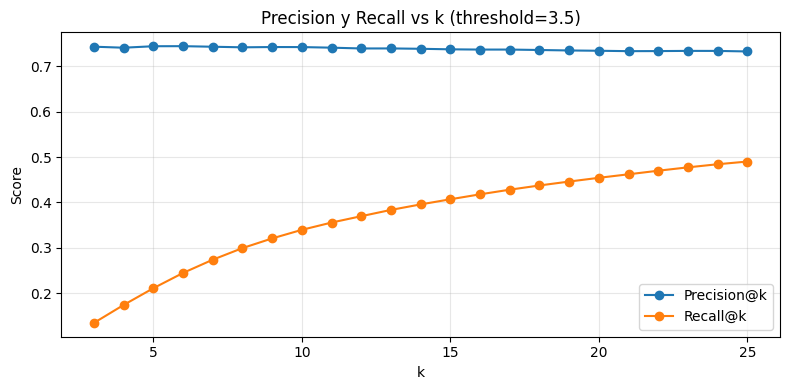

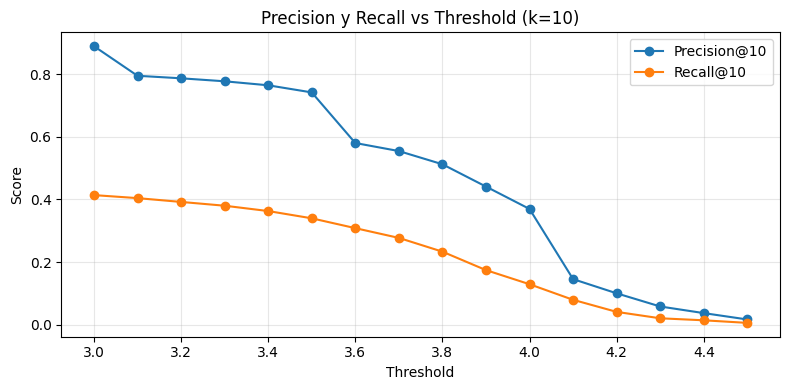


 Matriz final (userId × beerId) sin nulos:


beerId,5,6,7,9,10,11,14,15,17,19,...,74491,74530,74548,74579,74634,74827,74904,74986,75013,75086
userId,,,,,,,,,,,,,,,,,,,,,
1,3.614362,3.996703,3.520432,3.864237,3.727434,3.724483,3.915666,3.844499,3.649695,3.986211,...,3.717146,4.125757,3.997953,4.034263,3.781022,4.177826,4.036507,4.210541,4.037339,3.743536
3,1.000000,5.000000,3.500000,3.500000,3.472158,3.445325,3.694554,3.570250,3.381785,3.749790,...,3.479281,3.895766,3.760444,3.785356,3.485918,3.942219,3.765664,3.944756,3.804587,3.475096
4,3.705182,4.100406,3.590310,3.948802,4.000000,3.804235,4.028961,3.932373,3.734185,4.092720,...,3.815810,4.235438,4.110786,4.129325,3.850977,4.284047,4.118721,4.299434,4.144576,3.840431
5,3.618931,3.993261,3.475303,3.912091,3.777176,4.000000,3.949770,3.793542,3.702712,4.054677,...,3.705197,4.104792,3.991427,3.981059,3.668456,4.239425,3.988536,4.237546,4.113586,3.797211
6,3.613990,4.012320,3.512520,3.845177,3.743785,3.739074,4.000000,3.781996,3.658817,4.031942,...,3.732428,4.163171,4.001719,4.073237,3.745121,4.288715,4.101399,4.259783,4.085830,3.792104


In [127]:
#CODIGO AQUI

# El Mejor Filtro Colaborativo (SVD)
# ===============================
# 1) Función get_top_n(): obtiene las N mejores recomendaciones por usuario
# ---------------------------------------------------------------
def get_top_n(predictions, n=10):
    """Retorna las N mejores predicciones por usuario."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# ---------------------------------------------------------------
# 2) Reentrenar el mejor modelo (SVD) y obtener predicciones completas
# ---------------------------------------------------------------
svd.fit(trainset)
testset_full = trainset.build_anti_testset()
predictions_full = svd.test(testset_full)

# Obtener Top-N recomendaciones por usuario
top_n = get_top_n(predictions_full, n=5)

# Mostrar las 3 mejores cervezas recomendadas para Carl (userId=100)
print(" Top 3 cervezas recomendadas para Carl (userId=100):")
for i, (beer_id, rating) in enumerate(top_n[100][:3], start=1):
    beer_name = cervezas.loc[cervezas.beerId == int(beer_id), "beerName"].values
    print(f"{i}. {beer_name[0] if len(beer_name) > 0 else beer_id} (estimado: {rating:.2f})")

# ---------------------------------------------------------------
# 2) Dos predicciones aleatorias para cervezas no evaluadas por Carl
# ---------------------------------------------------------------
carl_id = 100
ya_rated = set(cervezas.loc[cervezas.userId == carl_id, 'beerId'].astype(int))
todas = set(cervezas['beerId'].astype(int).unique())
candidatas = sorted(todas - ya_rated)
random.seed(42)
muestras = random.sample(candidatas, 2)

print("\n Dos cervezas aleatorias no evaluadas por Carl y su rating estimado:")
for b in muestras:
    pred = svd.predict(carl_id, b)
    nombre = cervezas.loc[cervezas.beerId == b, 'beerName'].iloc[0]
    print(f"- [{b}] {nombre}: estimado = {pred.est:.2f}")

# ---------------------------------------------------------------
# 3) Calcular precisión@k y recall@k para evaluar el modelo
# ---------------------------------------------------------------
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Calcula precisión@k y recall@k promedio."""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

# Evaluación principal con k=10 y threshold=3.5
predictions = svd.test(testset)
prec, rec = precision_recall_at_k(predictions, k=10, threshold=3.5)
print("\n Métricas promedio (k=10, threshold=3.5):")
print(f"Precision@10: {np.mean(list(prec.values())):.4f}")
print(f"Recall@10: {np.mean(list(rec.values())):.4f}")

# ---------------------------------------------------------------
# 4) Barrido de k (3 a 25)
# ---------------------------------------------------------------
ks = list(range(3, 26))
prec_k, rec_k = [], []
for k in ks:
    p, r = precision_recall_at_k(predictions, k=k, threshold=3.5)
    prec_k.append(np.mean(list(p.values())))
    rec_k.append(np.mean(list(r.values())))

plt.figure(figsize=(8,4))
plt.plot(ks, prec_k, marker="o", label="Precision@k")
plt.plot(ks, rec_k, marker="o", label="Recall@k")
plt.xlabel("k"); plt.ylabel("Score")
plt.title("Precision y Recall vs k (threshold=3.5)")
plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# 5) Barrido de threshold (3.0 a 4.5)
# ---------------------------------------------------------------
ths = np.round(np.arange(3.0, 4.51, 0.1), 2)
prec_t, rec_t = [], []
for th in ths:
    p, r = precision_recall_at_k(predictions, k=10, threshold=th)
    prec_t.append(np.mean(list(p.values())))
    rec_t.append(np.mean(list(r.values())))

plt.figure(figsize=(8,4))
plt.plot(ths, prec_t, marker="o", label="Precision@10")
plt.plot(ths, rec_t, marker="o", label="Recall@10")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Precision y Recall vs Threshold (k=10)")
plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# 6) Matriz final (userId × beerId) sin valores nulos
# ---------------------------------------------------------------
df_full = pd.DataFrame(
    [(p.uid, p.iid, p.est) for p in predictions_full],
    columns=["userId","beerId","rating_pred"]
).drop_duplicates(subset=["userId","beerId"])

df_known = cervezas[["userId","beerId","rating"]].rename(columns={"rating":"rating_pred"})
df_union = pd.concat([df_known, df_full], ignore_index=True)\
             .drop_duplicates(subset=["userId","beerId"], keep="first")

matriz_final = df_union.pivot(index="userId", columns="beerId", values="rating_pred")\
                       .fillna(0.0)

print("\n Matriz final (userId × beerId) sin nulos:")
display(matriz_final.head())


3. Precision@10 y Recall@10 (k=10, threshold=3.5)

El modelo obtuvo una precision@10 alta (~0.74), lo que indica que la mayoría de las recomendaciones relevantes fueron efectivamente acertadas. El recall@10 (~0.34) es más bajo, mostrando que el modelo no recupera todas las cervezas relevantes. Aun así, el desempeño es bueno porque prioriza recomendar menos, pero recomendar bien.

4. Comportamiento al variar k (3 a 25)

Al aumentar k, la precisión disminuye levemente, ya que se agregan recomendaciones menos confiables al ranking. En cambio, el recall aumenta, porque considerar más cervezas permite recuperar más elementos relevantes. Esto refleja el trade-off típico entre precisión y cobertura.

5. Comportamiento al variar el threshold (3.0 a 4.5)

A medida que el threshold aumenta, tanto la precisión como el recall caen progresivamente, porque es más difícil que una predicción supere un nivel tan exigente. Con thresholds altos, las métricas se acercan a cero. Esto confirma que valores moderados como 3.5 son más razonables para evaluar relevancia.

6. Matriz final sin valores nulos

El modelo SVD permitió completar todas las combinaciones usuario-cerveza generando una matriz totalmente sin valores faltantes. Cada celda contiene un rating estimado para ese par, lo que habilita un sistema de recomendación funcional. Esta matriz es la base para sugerir cervezas incluso a usuarios con pocas evaluaciones.

# Conclusión

A lo largo de este trabajo construimos un sistema completo de análisis y predicción para series de tiempo y recomendación de cervezas. En la primera parte utilizamos Prophet y técnicas avanzadas con regresores y tuning, logrando capturar estacionalidad, mejorar el MAE y analizar el comportamiento del error. En la segunda parte exploramos métodos de recomendación basados en contenido, memoria y modelos, comparando su desempeño y seleccionando SVD como el más sólido. Finalmente evaluamos la calidad de las recomendaciones mediante métricas como precision@k y recall@k, y generamos una matriz completa sin valores faltantes para recomendar a cualquier usuario. En conjunto, el trabajo integra análisis exploratorio, modelamiento y evaluación, construyendo un sistema robusto y justificadamente seleccionado.





<center>
<img src ="https://i.gifer.com/origin/cb/cbd80e6045652ab123caffef72f29210_w200.gif" width = 400 />
